# Applying MPT and ML to a Yield Optimisation Problem 
A comparison of ML techniques to Modern Portfolio Theory approach when buiding a yeild aggregating stategy.

All datasets used in this Notebook can be found here: https://github.com/matt-nowakowski/ML_yield_optimisation

(Note: The notebook assumes it is being stored in the same directory as all the datasets.)

### Steps Outline:

1. Load the data from Dune Analytics
2. Clean the data
3. Theoretical Baseline and Risk Metrics
4. Apply MPT to obtain optimal allocation (Static and Dynamic Baseline)
5. Choose appropriate ML apporach and expand dataset
6. Train a set of ML models
7. Tune the models and hyperparameters
8. Asses Different Scenarios
9. Conclusion

### Loading the Data from Dune Analytics

The data has been downloaded from Dune at 04-07-2023 and contains daily datapoints going back as far as 09-2021.
All the data period will be shortened to start at 01-09-2022 (after the ETH merge).

In [75]:
import pandas as pd
from datetime import datetime

# Load the CSV files into pandas DataFrames

eth_lend_yield = pd.read_csv('eth_lend_yield.csv')
eth_lp_yield = pd.read_csv('eth_lp_yield.csv')
eth_stake_yield = pd.read_csv('eth_stake_yield.csv')


In [76]:
# Convert the 'time' column to datetime format and set it as the index

eth_lend_yield['block_day'] = pd.to_datetime(eth_lend_yield['block_day'])
eth_lp_yield['time'] = pd.to_datetime(eth_lp_yield['time'])
eth_stake_yield['time'] = pd.to_datetime(eth_stake_yield['time'])

eth_lend_yield.set_index('block_day', inplace=True)
eth_lp_yield.set_index('time', inplace=True)
eth_stake_yield.set_index('time', inplace=True)


In [77]:
# Sort the DataFrames in ascending order based on the 'time' column

eth_lend_yield.sort_index(inplace=True)
eth_lp_yield.sort_index(inplace=True)
eth_stake_yield.sort_index(inplace=True)


In [78]:
from datetime import datetime
import pytz  # Import the pytz module for working with time zones

# Define the time zone
tz = pytz.UTC

# Create tz-aware datetime objects
start_date = tz.localize(datetime(2022, 9, 1))
end_date = tz.localize(datetime(2023, 7, 4))

eth_lend_yield = eth_lend_yield.loc[start_date:end_date]
eth_lp_yield = eth_lp_yield.loc[start_date:end_date]
eth_stake_yield = eth_stake_yield.loc[start_date:end_date]


In [79]:
# Reset the index of each DataFrame to reassign the 'time' column as a regular column

eth_lend_yield.reset_index(inplace=True)
eth_lp_yield.reset_index(inplace=True)
eth_stake_yield.reset_index(inplace=True)

In [80]:
# Select the desired columns from each DataFrame

eth_lend_yield = eth_lend_yield[['block_day', 'deposit_apy']]
eth_lp_yield = eth_lp_yield[['time', 'Fee APR,%']]
eth_stake_yield = eth_stake_yield[['time', 'protocolAPR_withoutRestakedRewards']]

# Merge the DataFrames on the 'time' column

merged_df = pd.merge(eth_lend_yield, eth_lp_yield, left_on='block_day', right_on='time', how='inner')
merged_df = pd.merge(merged_df, eth_stake_yield, left_on='block_day', right_on='time', how='inner')

In [81]:
# Drop the redundant 'time' column and rearrange the columns

merged_df.drop(columns=['time_x', 'time_y'], inplace=True)
merged_df = merged_df[['block_day', 'Fee APR,%', 'deposit_apy', 'protocolAPR_withoutRestakedRewards']]

# Remove duplicate rows

merged_df.drop_duplicates(inplace=True)

# Rename the columns
merged_df = merged_df.rename(columns={
    'Fee APR,%': 'lp_yield',
    'deposit_apy': 'lend_yield',
    'protocolAPR_withoutRestakedRewards': 'stake_yield'
})

# Save the merged DataFrame to a new CSV file

merged_df.to_csv('eth_merged_yield_data.csv', index=False)


### Calucating Theoretical Baseline 

It is possible to establish a baseline or determine the best allocation of the three yield sources based on historical returns. By analyzing the historical performance of each yield source, you can identify the allocation that would have resulted in the highest return at the end of the period.

In [82]:
import pandas as pd
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the merged CSV file into a DataFrame
merged_df = pd.read_csv('eth_merged_yield_data.csv')

# Convert the 'block_day' column to datetime format (if needed)
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Calculate the average APY for each yield source
average_apy = merged_df.mean()

# Define the range of possible allocation weights (increments of 10%)
allocation_range = range(0, 101, 10)

# Initialize variables to track the best allocation
best_allocation = None
best_portfolio_return = -float('inf')

# Iterate over all allocation combinations
for weight_a in allocation_range:
    for weight_b in allocation_range:
        for weight_c in allocation_range:
            # Ensure the weights sum up to 100%
            if weight_a + weight_b + weight_c == 100:
                # Calculate the portfolio return for the allocation combination
                portfolio_return = (
                    average_apy['lp_yield'] * weight_a / 100 +
                    average_apy['lend_yield'] * weight_b / 100 +
                    average_apy['stake_yield'] * weight_c / 100
                )

                #   # Print the allocation weights and compounded return
                # print("Allocation Weights:", weight_a, weight_b, weight_c)
                # print("Compounded Return:", portfolio_return)
                # print()
                
                # Check if the current allocation has a higher return
                if portfolio_return > best_portfolio_return:
                    best_portfolio_return = portfolio_return
                    best_allocation = [weight_a, weight_b, weight_c]

# Print the best allocation and the corresponding portfolio return
print("Best Allocation:", best_allocation)
print("Portfolio Return:", best_portfolio_return)

# Print the average APY for each yield source
print("Average APY for LP Yield:", average_apy['lp_yield'])
print("Average APY for Lend Yield:", average_apy['lend_yield'])
print("Average APY for Stake Yield:", average_apy['stake_yield'])


Best Allocation: [100, 0, 0]
Portfolio Return: 0.14975355222934883
Average APY for LP Yield: 0.14975355222934883
Average APY for Lend Yield: 0.019159168068296407
Average APY for Stake Yield: 0.05531270693042473


Calculating baseline that way does not give us any useful inight however. Since we know what return each of the sources had, in retorspect one will always choose the one with the highest return and will never "diverisify" because that would mean giving up returns for nothing. Looking froward however, one does not know which option will perfom best, or has no 100% certainty that the expected return will not change, hence taakign 'risk' into account is neccesary.

The volatility of each of those yileds might be a good way of indicating risk.

In [83]:
# Calculate the volatility (standard deviation) of each yield source

volatility_lp = merged_df['lp_yield'].std()
volatility_lend = merged_df['lend_yield'].std()
volatility_stake = merged_df['stake_yield'].std()

# Print the volatility of each yield source
print("Volatility of LP Yield:", volatility_lp)
print("Volatility of Lend Yield:", volatility_lend)
print("Volatility of Stake Yield:", volatility_stake)


Volatility of LP Yield: 0.21502384236872837
Volatility of Lend Yield: 0.028205801320524453
Volatility of Stake Yield: 0.012063774404790686


We can see above that although LP yield has the highest APY, it also has the highest volatility. The ratio between APY and volatility can provide a measure of risk-adjusted returns and serve as an indicator to evaluate investment opportunities. One commonly used ratio is the Sharpe ratio.

The Sharpe ratio is calculated as the ratio of the average excess return (APY minus a risk-free rate) to the standard deviation (volatility) of the returns. It measures the excess return generated per unit of risk taken.

In [84]:
# Given average APY values
average_apy_lp = average_apy['lp_yield']
average_apy_lend = average_apy['lend_yield']
average_apy_stake = average_apy['stake_yield']

# Assuming risk-free rate as 0%
risk_free_rate = 0

# Calculate the excess return
excess_return_lp = average_apy_lp - risk_free_rate
excess_return_lend = average_apy_lend - risk_free_rate
excess_return_stake = average_apy_stake - risk_free_rate

# Calculate the Sharpe ratio
sharpe_ratio_lp = excess_return_lp / volatility_lp
sharpe_ratio_lend = excess_return_lend / volatility_lend
sharpe_ratio_stake = excess_return_stake / volatility_stake

# Print the Sharpe ratio for each yield source
print("Sharpe Ratio for LP Yield:", sharpe_ratio_lp)
print("Sharpe Ratio for Lend Yield:", sharpe_ratio_lend)
print("Sharpe Ratio for Stake Yield:", sharpe_ratio_stake)


Sharpe Ratio for LP Yield: 0.6964509171617704
Sharpe Ratio for Lend Yield: 0.6792633845277389
Sharpe Ratio for Stake Yield: 4.585024974311466


A higher Sharpe ratio indicates a more favorable risk-adjusted return. It suggests that an investment generates higher returns relative to the amount of risk taken. Conversely, a lower Sharpe ratio implies lower risk-adjusted returns. 

This suggests there is probably a middle-ground that accounts for the safer source (staking) and discounts the most risky but return-heavy source (LP). You can use Modern Portfolio Theory (MPT) to find a middle ground.

To implement this, you can introduce a risk aversion parameter or a preference weight to control the trade-off between risk and return. By assigning a higher weight to risk, you would prefer a safer portfolio, and by assigning a higher weight to return, you would prefer a higher-return portfolio.

### Applying Static MPT

To perform modern portfolio theory (MPT) and obtain an optimal allocation of the budget across the three sources of yield, you need to consider the historical returns and risk of each asset. MPT aims to find the optimal portfolio allocation that maximizes the return for a given level of risk or minimizes the risk for a given level of return.

In [85]:
import numpy as np
import cvxpy as cp
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
sharpe_ratios = np.array([sharpe_ratio_lp, sharpe_ratio_lend, sharpe_ratio_stake])
average_apy = np.array([average_apy_lp, average_apy_lend, average_apy_stake])
std_devs = np.array([volatility_lp, volatility_lend, volatility_stake])

# Number of assets
num_assets = len(sharpe_ratios)

# Risk aversion factor
risk_aversion = 0.5

# Define the variable for weights
weights = cp.Variable(num_assets)

# Define the expected return and risk
expected_return = cp.sum(weights * average_apy)
risk = cp.quad_form(weights, np.diag(std_devs))

# Define the objective to maximize the utility function
objective = cp.Maximize(expected_return - risk_aversion * risk)

# Define the constraints - sum of weights equal to 1 and weights >= 0
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal weights for the efficient frontier
optimal_weights = weights.value

# Print the optimal weights
for i in range(num_assets):
    print(f"{['LP Yield', 'Lend Yield', 'Stake Yield'][i]}: {optimal_weights[i]}")


LP Yield: 0.4690023226142483
Lend Yield: 6.870230689143623e-23
Stake Yield: 0.5309976773857518


It can be seen above, that after wanting to lower the risk of the overall portfolio, more of it was allocated to the yield source with higher sharpe ratio. The risk aversion factor of 0.5 gives equal weights to the importance of return-heavy source and that of the least risky soruce.

Below it can be seen how that alocation changes with different risk avesrion values.

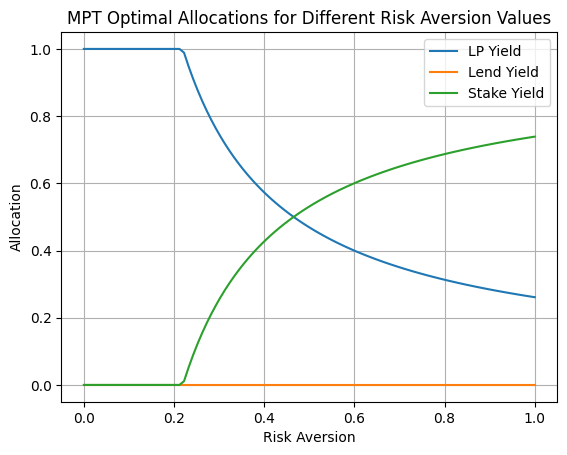

In [86]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
sharpe_ratios = np.array([sharpe_ratio_lp, sharpe_ratio_lend, sharpe_ratio_stake])
average_apy = np.array([average_apy_lp, average_apy_lend, average_apy_stake])
std_devs = np.array([volatility_lp, volatility_lend, volatility_stake])

# Number of assets
num_assets = len(sharpe_ratios)

# Range of risk aversion values
risk_aversion_values = np.linspace(0, 1, 100)

# Empty arrays to store optimal allocations
optimal_allocations = np.zeros((len(risk_aversion_values), num_assets))

# Solve optimization problem for different risk aversion values
for i, risk_aversion in enumerate(risk_aversion_values):
    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal weights
    optimal_allocations[i] = weights.value

# Plot the allocations for different risk aversion values
plt.plot(risk_aversion_values, optimal_allocations[:, 0], label='LP Yield')
plt.plot(risk_aversion_values, optimal_allocations[:, 1], label='Lend Yield')
plt.plot(risk_aversion_values, optimal_allocations[:, 2], label='Stake Yield')
plt.xlabel('Risk Aversion')
plt.ylabel('Allocation')
plt.title('MPT Optimal Allocations for Different Risk Aversion Values')
plt.legend()
plt.grid(True)
plt.show()


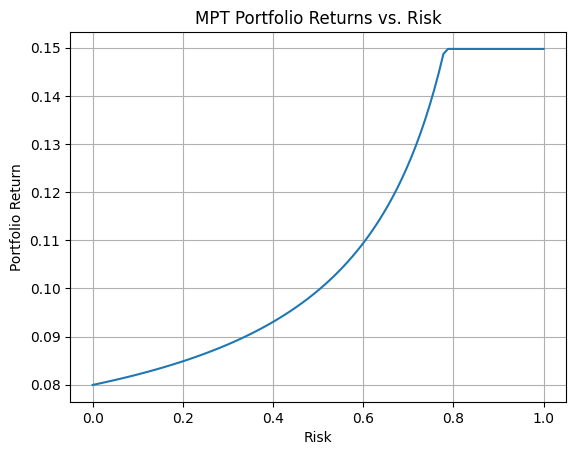

In [87]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
sharpe_ratios = np.array([sharpe_ratio_lp, sharpe_ratio_lend, sharpe_ratio_stake])
average_apy = np.array([average_apy_lp, average_apy_lend, average_apy_stake])
std_devs = np.array([volatility_lp, volatility_lend, volatility_stake])

# Number of assets
num_assets = len(sharpe_ratios)

# Range of risk aversion values
risk_aversion_values = np.linspace(0, 1, 100)

# Empty arrays to store optimal allocations and returns
optimal_allocations = np.zeros((len(risk_aversion_values), num_assets))
portfolio_returns = []

# Solve optimization problem for different risk aversion values
for i, risk_aversion in enumerate(risk_aversion_values):
    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal weights
    optimal_allocations[i] = weights.value

    # Calculate the portfolio return based on the optimal allocation
    portfolio_return = np.dot(weights.value, average_apy)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio returns against the flipped risk aversion values
plt.plot(risk_aversion_values[::-1], portfolio_returns)
plt.xlabel('Risk')
plt.ylabel('Portfolio Return')
plt.title('MPT Portfolio Returns vs. Risk')
plt.grid(True)
plt.show()

## Applying Dynamic MPT Model

For our evaluation of how this approach would work "in-flight", an agent can be designed that adjusts the optimal allocation of a moderate risk portfolio (risk_aversion = 0.5) based on the efficient frontier graph calculated at every time step based on previous 30 time steps’ performance. Then the portfolio value is calculated and compared to the return from just holding the same portfolio throught the entire duration of the dataset.

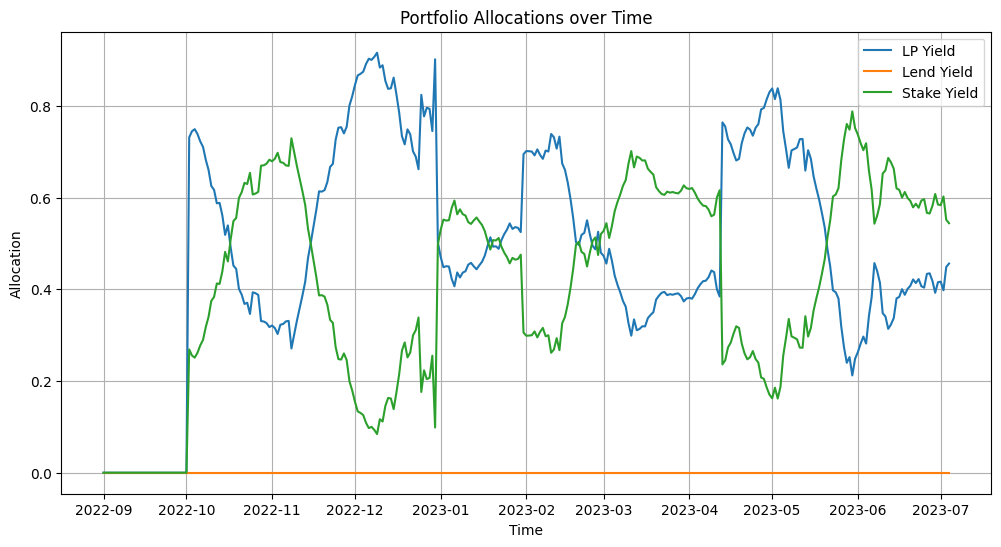

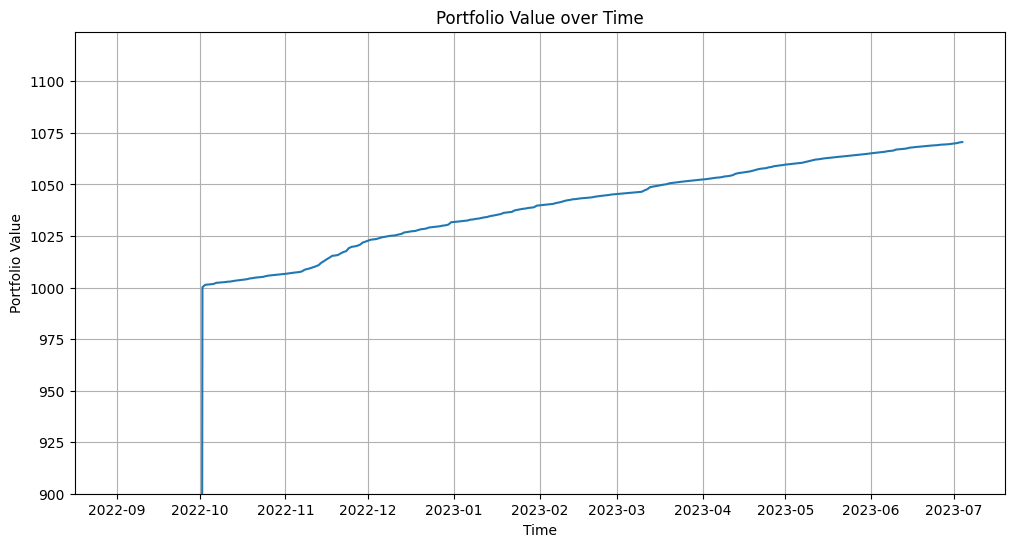

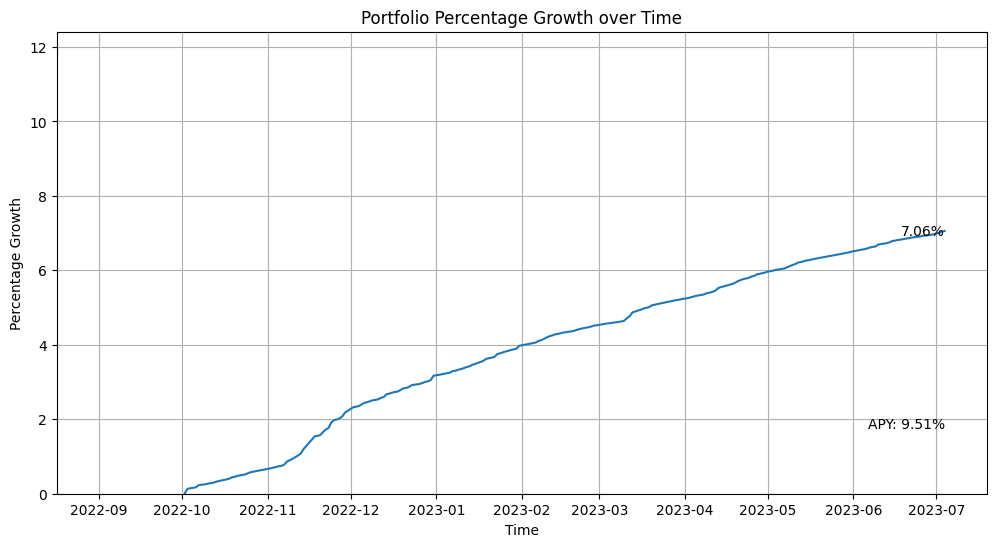

In [88]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 31  # Number of previous time steps to consider (including the current step)
num_assets = 3  # Number of assets

# Initialize the portfolio allocations and values
portfolio_allocations = np.zeros((len(merged_df), num_assets))
portfolio_values = np.zeros(len(merged_df))
initial_investment = 1000  # Initial investment amount

# Iterate through the data to calculate allocations and track portfolio performance
for i in range(window_size, len(merged_df)):
    # Select the data for the previous window_size time steps
    prev_data = merged_df.iloc[i-window_size+1:i+1]

    # Extract the average APYs and standard deviations
    average_apy = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].mean().values
    std_devs = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].std().values

    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal allocation for the current time step
    portfolio_allocations[i] = weights.value

    # Calculate the portfolio value based on the allocation and annualized APYs
    allocation = portfolio_allocations[i]
    annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1

    # Calculate the portfolio return for the current time step
    portfolio_return = np.dot(allocation, daily_returns)

    # Calculate the portfolio value by compounding the returns
    if i == window_size:
        portfolio_values[i] = initial_investment * (1 + portfolio_return)
    else:
        portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

# Calculate the percentage growth of the portfolio
portfolio_percentage_growth = (portfolio_values - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(merged_df)-31
apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

# Plot the portfolio allocations over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_allocations[:, 0], label='LP Yield')
plt.plot(merged_df['block_day'], portfolio_allocations[:, 1], label='Lend Yield')
plt.plot(merged_df['block_day'], portfolio_allocations[:, 2], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title('Portfolio Allocations over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Time')
plt.ylim(bottom=initial_investment * 0.9)  # Set the lower y-axis limit to 90% of the initial investment
plt.grid(True)
plt.show()

# Plot the percentage growth of the portfolio
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_percentage_growth)
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Portfolio Percentage Growth over Time')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1], f'{portfolio_percentage_growth[-1]:.2f}%',
         ha='right', va='center')

# Print the APY for the given portfolio growth
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 5, f'APY: {apy:.2%}', ha='right', va='top')

plt.show()


The above agent doesn't take into account the existence of transaction fees, which will hugely imact the daily transactions required to rebalance the portfolio. The fee of a transaction is not related to the size of the transferred ETH amount, so we can enrich the dataset by looking at the daily average transaction fee and see how moving our funds around will be impacted by those fees.

In [89]:
import pandas as pd

# Read the CSV files
eth_yield_data = pd.read_csv('eth_merged_yield_data.csv')
gas_fees_data = pd.read_csv('eth_gas_fees.csv')

# Convert the date formats to a common format for comparison and matching
eth_yield_data['block_day'] = pd.to_datetime(eth_yield_data['block_day']).dt.date
gas_fees_data['block_day'] = pd.to_datetime(gas_fees_data['block_day']).dt.date

gas_fees_data = gas_fees_data[['block_day', 'median_gas']]

# Merge the two DataFrames on the "block_day" column
merged_data = eth_yield_data.merge(gas_fees_data, on='block_day', how='left')

# Save the merged DataFrame to a new CSV file
merged_data.to_csv('eth_merged_yield_data_with_gas_fees.csv', index=False)

Now that we have the transaction fees for each day we can use the information about the price of ethereum to infer the transaction cost in USD.

In [90]:
import pandas as pd

# Read the CSV files
eth_yield_data_with_fees = pd.read_csv('eth_merged_yield_data_with_gas_fees.csv')
price_data = pd.read_csv('eth_price_data_new.csv')

# Convert the date formats to a common format for comparison and matching
eth_yield_data_with_fees['block_day'] = pd.to_datetime(eth_yield_data_with_fees['block_day']).dt.date
price_data['block_day'] = pd.to_datetime(price_data['block_day']).dt.date

price_data = price_data[['block_day', 'close_price']]

# Merge the two DataFrames on the "block_day" column
merged_data = eth_yield_data_with_fees.merge(price_data, on='block_day', how='left')

# Save the merged DataFrame to a new CSV file
merged_data.to_csv('eth_merged_yield_data_with_gas_fees_and_price.csv', index=False)

In [91]:
import pandas as pd

# Read the CSV file
data = pd.read_csv('eth_merged_yield_data_with_gas_fees_and_price.csv')

# Given: 1 Gwei is 0.000000001 ETH
gwei_to_eth = 0.000000001

# Convert median_gas (in Gwei) to ETH
data['gas_eth'] = data['median_gas'] * gwei_to_eth

# Clean the closing_price column by removing commas and converting it to numeric
data['close_price'] = data['close_price'].replace({',': ''}, regex=True).astype(float)

# Calculate the fee_usd using the ETH price in USD (column: closing_price)
data['fee_usd'] = data['gas_eth'] * data['close_price']

# Drop the median_gas and gas_eth columns
data.drop(columns=['median_gas', 'gas_eth'], inplace=True)

# Save the modified data to a new CSV file (optional)
data.to_csv('eth_full_data.csv', index=False)


Now we can include the gas fee information in our agent's analysis, and deduce the fee from  our daily return everytime we make a transaction (ie. on sell and buy orders).

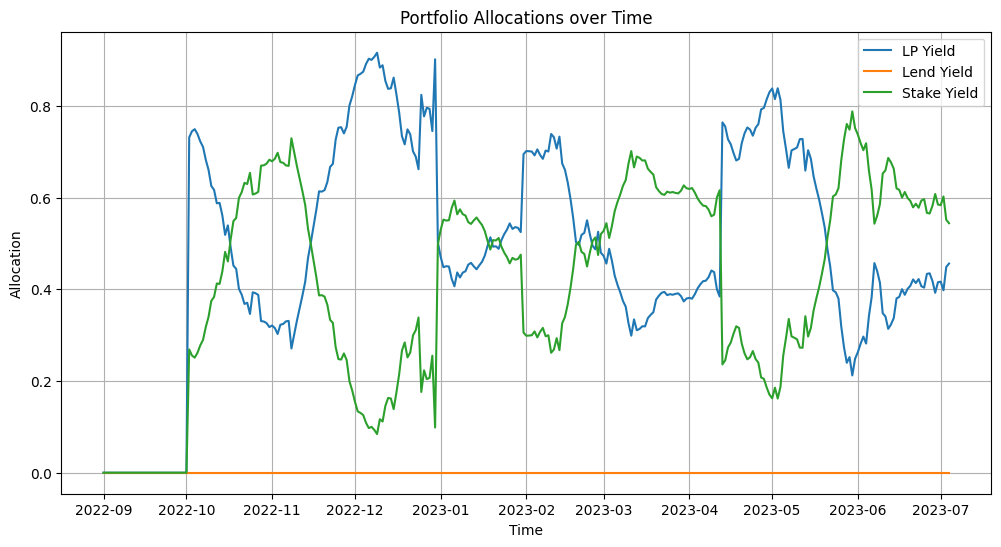

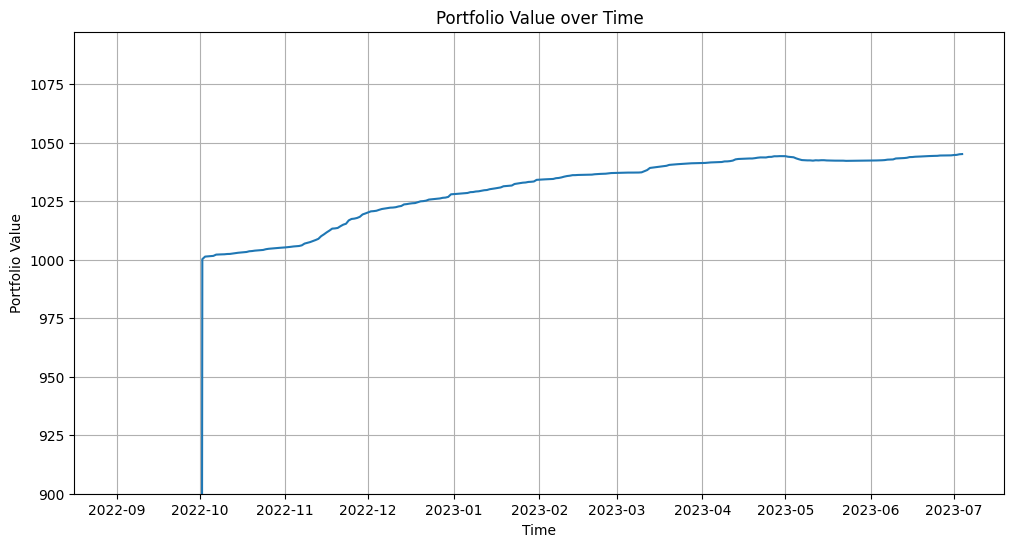

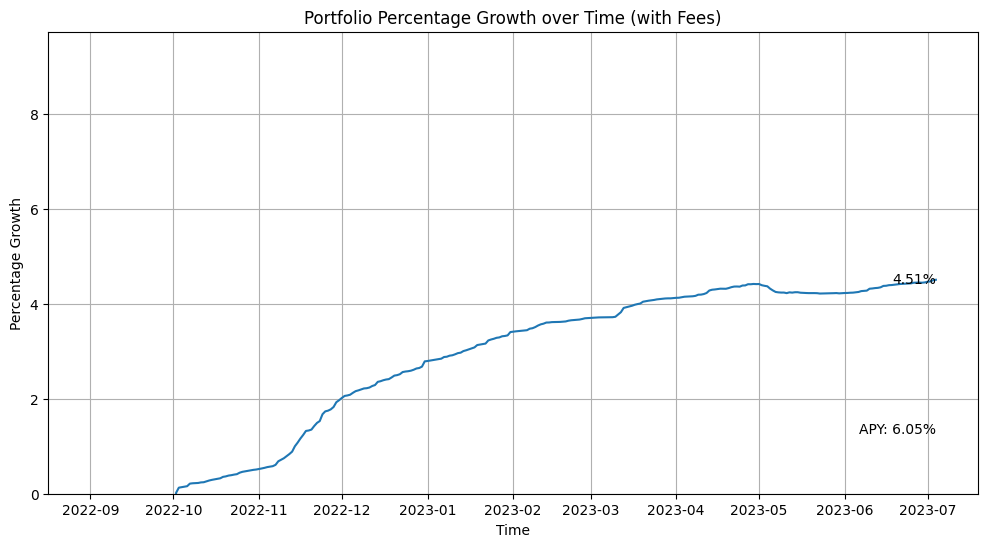

In [92]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 31  # Number of previous time steps to consider (including the current step)
num_assets = 3  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('eth_full_data.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize the portfolio allocations and values
portfolio_allocations = np.zeros((len(merged_df), num_assets))
portfolio_values = np.zeros(len(merged_df))
initial_investment = 1000  # Initial investment amount

# Iterate through the data to calculate allocations and track portfolio performance
for i in range(window_size, len(merged_df)):
    # Select the data for the previous window_size time steps
    prev_data = merged_df.iloc[i-window_size+1:i+1]

    # Extract the average APYs and standard deviations
    average_apy = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].mean().values
    std_devs = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].std().values

    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal allocation for the current time step
    portfolio_allocations[i] = weights.value

    # Calculate the portfolio value based on the allocation and annualized APYs
    allocation = portfolio_allocations[i]
    annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
    daily_returns = (1 + annualized_apy) ** (1/365) - 1

    # Calculate the portfolio return for the current time step
    # Adjust the daily returns for gas fees (buying and selling)
    adjusted_daily_returns = daily_returns - 2 * gas_fee
    portfolio_return = np.dot(allocation, adjusted_daily_returns)

    # Calculate the portfolio value by compounding the returns
    if i == window_size:
        portfolio_values[i] = initial_investment * (1 + portfolio_return)
    else:
        portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

# Calculate the percentage growth of the portfolio
portfolio_percentage_growth = (portfolio_values - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(merged_df)-31
apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

# Plot the portfolio allocations over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_allocations[:, 0], label='LP Yield')
plt.plot(merged_df['block_day'], portfolio_allocations[:, 1], label='Lend Yield')
plt.plot(merged_df['block_day'], portfolio_allocations[:, 2], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title('Portfolio Allocations over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Time')
plt.ylim(bottom=initial_investment * 0.9)  # Set the lower y-axis limit to 90% of the initial investment
plt.grid(True)
plt.show()

# Plot the percentage growth of the portfolio
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_percentage_growth)
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Portfolio Percentage Growth over Time (with Fees)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1], f'{portfolio_percentage_growth[-1]:.2f}%',
         ha='right', va='center')

# Print the APY for the given portfolio growth
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3, f'APY: {apy:.2%}', ha='right', va='top')

plt.show()


We can see that the APY is now significanlty lower when accounting for the fees. Perhaps the reallocation should not occur everyday, but less often to incur less fees. Below is a calulation representing weekly rebalancing of the portfolio.

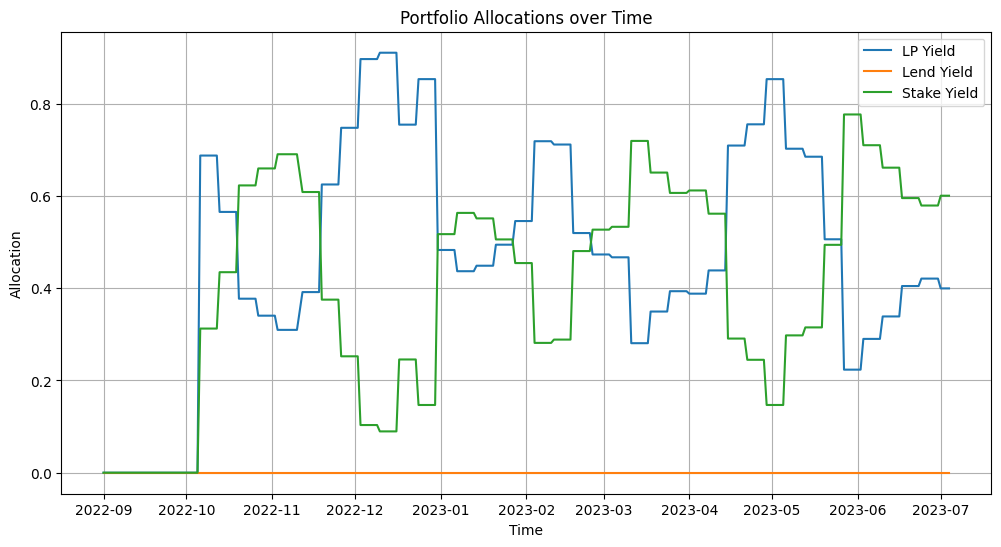

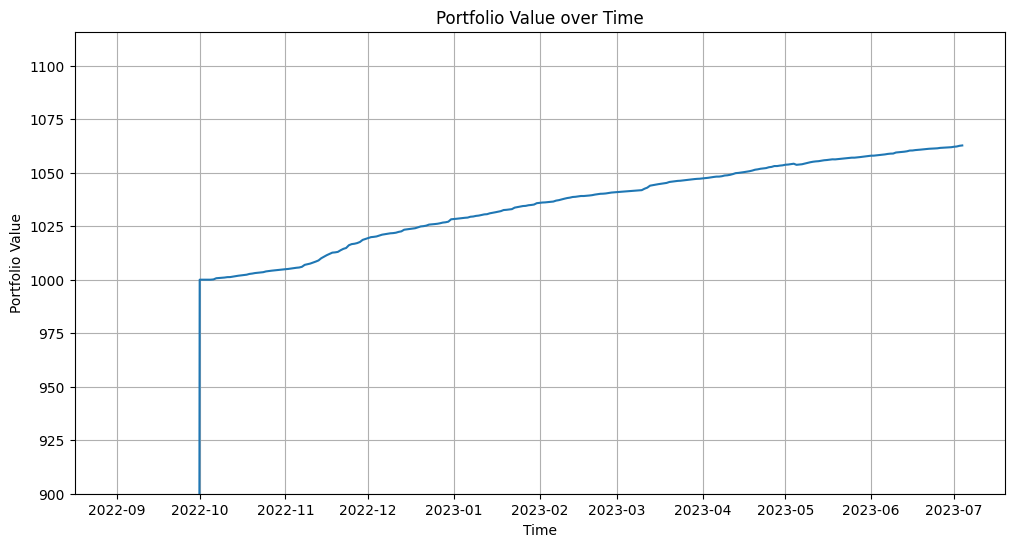

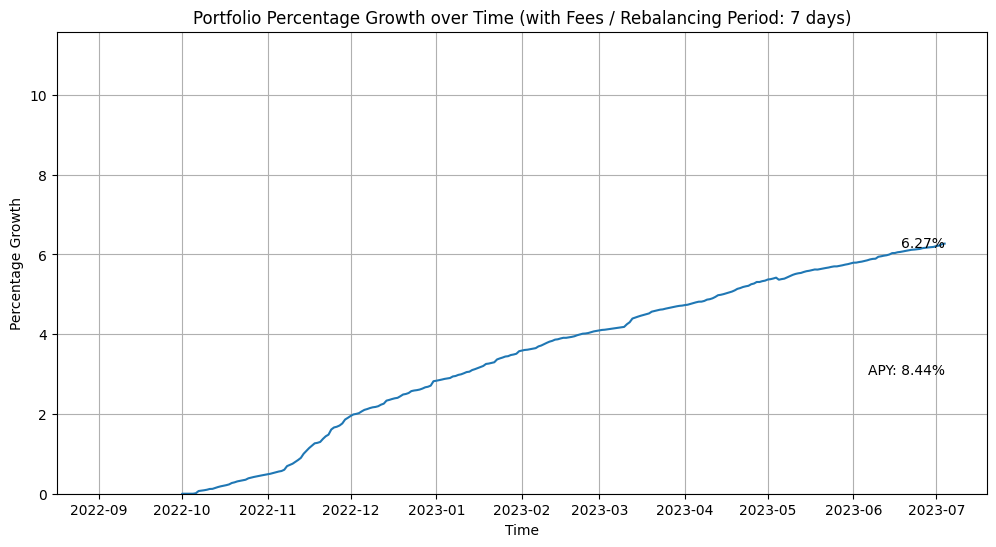

In [93]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
rebalancing_period = 7  # Rebalance every 7 days
window_size = 30  # Number of previous time steps to consider for efficient frontier
num_assets = 3  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('eth_full_data.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize the portfolio allocations and values
portfolio_allocations = np.zeros((len(merged_df), num_assets))
portfolio_values = np.zeros(len(merged_df))
initial_investment = 1000  # Initial investment amount

for i in range(window_size, len(merged_df)):
    if i % rebalancing_period == 0:
    # Select the data for the previous window_size time steps
        prev_data = merged_df.iloc[i-window_size+1:i+1]

    # Extract the average APYs and standard deviations
        average_apy = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].mean().values
        std_devs = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].std().values

    # Define the variable for weights
        weights = cp.Variable(num_assets)

    # Define the expected return and risk
        expected_return = cp.sum(weights * average_apy)
        risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
        objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
        constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # Store the optimal allocation for the current time step
        portfolio_allocations[i] = weights.value

    else:
        # Carry forward the previous allocation for non-rebalancing days
        portfolio_allocations[i] = portfolio_allocations[i-1]

    # Calculate the portfolio value based on the allocation and annualized APYs
    allocation = portfolio_allocations[i]
    annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate gas fee only on rebalance days
    if (i + 1) % rebalancing_period == 0:
        gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
    else:
        gas_fee = 0
    
    # Calculate the daily portfolio return for the current time step
    adjusted_daily_returns = daily_returns - 2 * gas_fee
    portfolio_return = np.dot(allocation, adjusted_daily_returns)

    # Calculate the portfolio value by compounding the returns
    if i == window_size:
        portfolio_values[i] = initial_investment * (1 + portfolio_return)
    else:
        portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

# Calculate the percentage growth of the portfolio
portfolio_percentage_growth = (portfolio_values - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(merged_df)-31
apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

# Plot the portfolio allocations over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_allocations[:, 0], label='LP Yield')
plt.plot(merged_df['block_day'], portfolio_allocations[:, 1], label='Lend Yield')
plt.plot(merged_df['block_day'], portfolio_allocations[:, 2], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title('Portfolio Allocations over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Time')
plt.ylim(bottom=initial_investment * 0.9)  # Set the lower y-axis limit to 90% of the initial investment
plt.grid(True)
plt.show()

# Plot the percentage growth of the portfolio
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_percentage_growth)
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Portfolio Percentage Growth over Time (with Fees / Rebalancing Period: 7 days)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1], f'{portfolio_percentage_growth[-1]:.2f}%',
         ha='right', va='center')

# Print the APY for the given portfolio growth
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3, f'APY: {apy:.2%}', ha='right', va='top')

plt.show()

As we can see above, rebalancing the portfolio less often strikes a good compromise between updating the allocations based on new data, and saving funds on transaction fees. Perhaps an optimal number of days can be found by experimenting with different rebalancing periods.

Best Rebalancing Period: 15 days
Best APY: 9.15%
Best Portfolio Percentage Growth: 6.80%


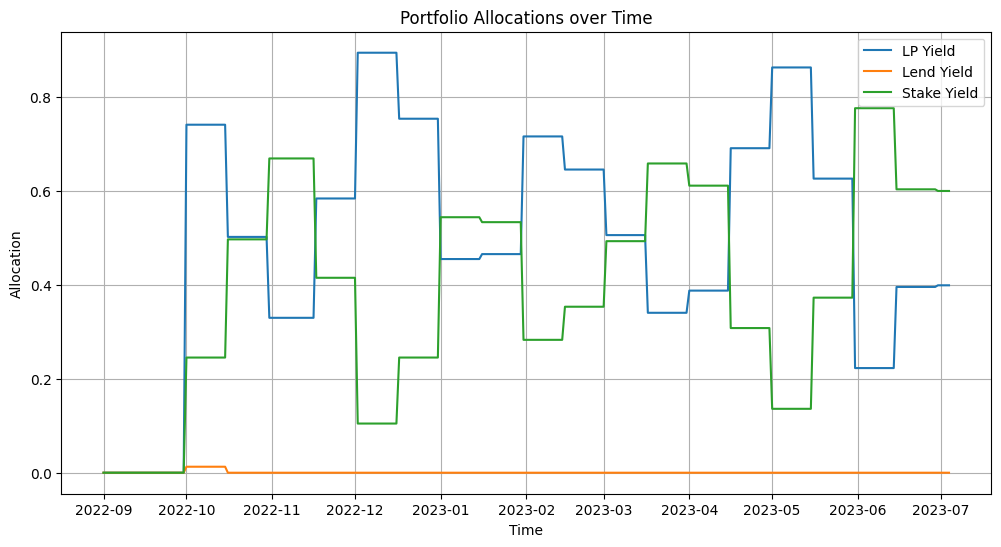

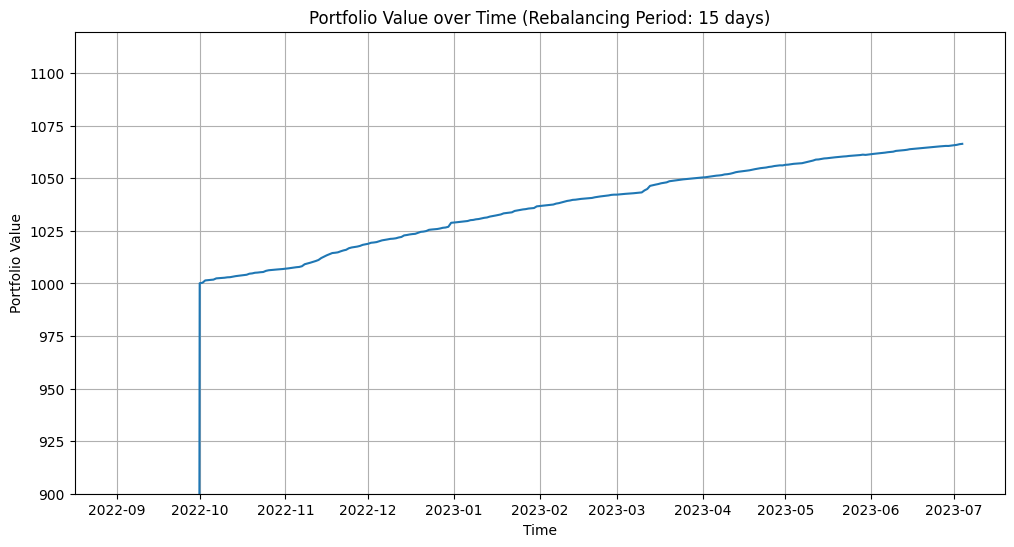

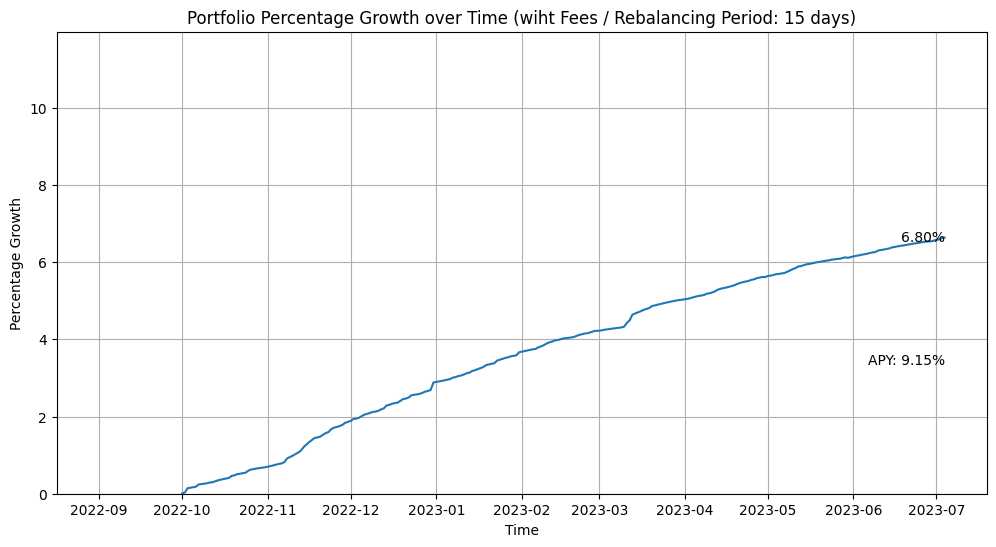

In [94]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 30  # Number of previous time steps to consider for efficient frontier
num_assets = 3  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('eth_full_data.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize variables to track the best rebalancing period and performance
best_rebalancing_period = None
best_apy = -float('inf')
best_portfolio_growth = -float('inf')

# Iterate through different rebalancing periods
for rebalancing_period in range(1, 31):
    portfolio_allocations = np.zeros((len(merged_df), num_assets))
    portfolio_values = np.zeros(len(merged_df))
    initial_investment = 1000  # Initial investment amount

    # Iterate through the data to calculate allocations and track portfolio performance
    for i in range(window_size, len(merged_df)):
        if i % rebalancing_period == 0:
        # Select the data for the previous window_size time steps
            prev_data = merged_df.iloc[i-window_size+1:i+1]

        # Extract the average APYs and standard deviations
            average_apy = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].mean().values
            std_devs = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].std().values

        # Define the variable for weights
            weights = cp.Variable(num_assets)

        # Define the expected return and risk
            expected_return = cp.sum(weights * average_apy)
            risk = cp.quad_form(weights, np.diag(std_devs))

        # Define the objective to maximize the utility function
            objective = cp.Maximize(expected_return - risk_aversion * risk)

        # Define the constraints - sum of weights equal to 1 and weights >= 0
            constraints = [cp.sum(weights) == 1, weights >= 0]

        # Solve the optimization problem
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # Store the optimal allocation for the current time step
            portfolio_allocations[i] = weights.value

        else:
            # Carry forward the previous allocation for non-rebalancing days
            portfolio_allocations[i] = portfolio_allocations[i-1]

        # Calculate the portfolio value based on the allocation and annualized APYs
        allocation = portfolio_allocations[i]
        annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
        
        # Calculate gas fee only on rebalance days
        if (i + 1) % rebalancing_period == 0:
            gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
        else:
            gas_fee = 0
        
        daily_returns = (1 + annualized_apy) ** (1/365) - 1

        # Calculate the portfolio return for the current time step
        adjusted_daily_returns = daily_returns - 2 * gas_fee
        portfolio_return = np.dot(allocation, adjusted_daily_returns)

        # Calculate the portfolio value by compounding the returns
        if i == window_size:
            portfolio_values[i] = initial_investment * (1 + portfolio_return)
        else:
            portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

      # Calculate the percentage growth of the portfolio for the best rebalancing period
    portfolio_percentage_growth = ((portfolio_values - initial_investment) / initial_investment) * 100
             
    # Calculate the APY for the given portfolio growth
    num_days = len(merged_df)-31
    apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

    # Compare APY and portfolio growth with the best values
    if apy > best_apy:
        best_apy = apy
        best_rebalancing_period = rebalancing_period
        best_portfolio_growth = (portfolio_values[-1] - initial_investment) / initial_investment * 100
        best_portfolio_allocations = portfolio_allocations.copy()


# Print the best rebalancing period and performance metrics
print(f"Best Rebalancing Period: {best_rebalancing_period} days")
print(f"Best APY: {best_apy:.2%}")
print(f"Best Portfolio Percentage Growth: {best_portfolio_growth:.2f}%")

# Plot the portfolio allocations over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 0], label='LP Yield')
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 1], label='Lend Yield')
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 2], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title('Portfolio Allocations over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for the best rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title(f'Portfolio Value over Time (Rebalancing Period: {best_rebalancing_period} days)')
plt.ylim(bottom=initial_investment * 0.9)  # Set the lower y-axis limit to 90% of the initial investment
plt.grid(True)
plt.show()

# Plot the percentage growth of the portfolio for the best rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_percentage_growth)
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title(f'Portfolio Percentage Growth over Time (wiht Fees / Rebalancing Period: {best_rebalancing_period} days)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1], f'{best_portfolio_growth:.2f}%',
         ha='right', va='center')

# Print the APY for the given portfolio growth
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3, f'APY: {best_apy:.2%}', ha='right', va='top')

plt.show()


This is a relatively simple approach and could be further tuned, by adding covariance (corelation) between assets and transitioning into a more rigid MVO (Mean-Variance Optimization) appraoch.

Mean-Variance Optimization is one of the practical implementations of Modern Portfolio Theory and a quantitative technique used to find the optimal allocation of assets in a portfolio that maximizes the expected return while minimizing the portfolio's variance (or standard deviation) of returns adn taking into account their covariance (or correlation) with other assets. By constructing a covariance matrix of asset returns, MVO finds the weights of assets in the portfolio that achieve the desired risk-return trade-off.

### Choosing appropriate ML apporach and Data Expansion 

Now that the MPT approach gave a set of allocations for different risk tolerances, it would be interesting to explore the differences in those sets of allocations if suggested by a Machine Learning Algorythm. 

For a task like portfolio optimization, where you want to predict asset allocations based on various input features, regression models are commonly used. Some suitable models to consider are:

- Linear Regression: A simple model that establishes linear relationships between input features and predicted allocations.
- Random Forest Regressor: An ensemble method that can handle non-linear relationships and interactions between features.

In this context, the target variable would be the actual optimal asset allocations that were obtained using the MPT/pseudo-MVO approach for each rebalancing period. Essentially, we're trying to predict these allocations using the input features.

Using the allocations obtained from the MPT approach as the target variable however, in the ML model would create a circular dependency and hinder the comparison between the two methods. This would essentially mean that the ML model is learning to replicate the MPT's decisions, and it wouldn't provide a fair assessment of the ML approach's capabilities.

To avoid this issue and conduct a meaningful comparison, the following can be considered:

- Feature Engineering: Use historical data up to each rebalancing period as features for training your ML model. These features could include price changes, volatility, Sharpe ratios, and any other relevant information. Do not include any information related to the MVO-calculated allocations.

- New Target Variable: Instead of using the MVO allocations as the target, you'll need to create a new target variable for your ML model. This target should be something you can measure or calculate independently, such as the actual portfolio returns achieved in the subsequent period after the rebalancing.


Althought the latter approch would allow to train the ML model  to learn patterns and relationships that can help it make predictions without direct knowledge of the MVO allocations, it would do so by predicting this new target variable (e.g., portfolio returns for the next period) based on the historical features. This information is not helpful in a real-life scenario, where we need to know how to allocate our budgets.

This leaves us with the first option, where we will attempt to "enrich" the MPT results by taking the suggested output (allocations), feeding it as target varibale, alongside more features, to see if any additional relationships are discovered, that could help us in further turning the allocations.

In [95]:
import numpy as np
import cvxpy as cp
import pandas as pd

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 31  # Number of previous time steps to consider (including the current step)
num_assets = 3  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('eth_full_data.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize the portfolio allocations and values
portfolio_allocations = np.zeros((len(merged_df), num_assets))
portfolio_values = np.zeros(len(merged_df))
initial_investment = 1000  # Initial investment amount

# Iterate through the data to calculate allocations and track portfolio performance
for i in range(window_size, len(merged_df)):
    # Select the data for the previous window_size time steps
    prev_data = merged_df.iloc[i-window_size+1:i+1]

    # Extract the average APYs and standard deviations
    average_apy = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].mean().values
    std_devs = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].std().values

    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal allocation for the current time step
    portfolio_allocations[i] = weights.value

    # Calculate the portfolio value based on the allocation and annualized APYs
    allocation = portfolio_allocations[i]
    annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
    daily_returns = (1 + annualized_apy) ** (1/365) - 1

    # Calculate the portfolio return for the current time step
    # Adjust the daily returns for gas fees (buying and selling)
    adjusted_daily_returns = daily_returns - 2 * gas_fee
    portfolio_return = np.dot(allocation, adjusted_daily_returns)

    # Calculate the portfolio value by compounding the returns
    if i == window_size:
        portfolio_values[i] = initial_investment * (1 + portfolio_return)
    else:
        portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

# Calculate the percentage growth of the portfolio
portfolio_percentage_growth = (portfolio_values - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(merged_df)-31
apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

# Calculate and add new columns to the DataFrame
merged_df['lp_allocation'] = portfolio_allocations[:, 0]
merged_df['lend_allocation'] = portfolio_allocations[:, 1]
merged_df['stake_allocation'] = portfolio_allocations[:, 2]

# Calculate moving average 30-day return, Sharpe ratio, and volatility for each asset
merged_df['lp_30ma_return'] = merged_df['lp_yield'].rolling(window=30).mean()
merged_df['lend_30ma_return'] = merged_df['lend_yield'].rolling(window=30).mean()
merged_df['stake_30ma_return'] = merged_df['stake_yield'].rolling(window=30).mean()

merged_df['lp_30ma_volatility'] = merged_df['lp_yield'].rolling(window=30).std()
merged_df['lend_30ma_volatility'] = merged_df['lend_yield'].rolling(window=30).std()
merged_df['stake_30ma_volatility'] = merged_df['stake_yield'].rolling(window=30).std()

merged_df['lp_30ma_sharpe_ratio'] = (merged_df['lp_30ma_return'] / merged_df['lp_30ma_volatility']) * np.sqrt(365)
merged_df['lend_30ma_sharpe_ratio'] = (merged_df['lend_30ma_return'] / merged_df['lend_30ma_volatility']) * np.sqrt(365)
merged_df['stake_30ma_sharpe_ratio'] = (merged_df['stake_30ma_return'] / merged_df['stake_30ma_volatility']) * np.sqrt(365)

# Print or visualize the added columns if needed
print(merged_df[['block_day', 'lp_allocation', 'lend_allocation', 'stake_allocation', 'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']])


     block_day  lp_allocation  lend_allocation  stake_allocation  \
0   2022-09-01       0.000000     0.000000e+00          0.000000   
1   2022-09-02       0.000000     0.000000e+00          0.000000   
2   2022-09-03       0.000000     0.000000e+00          0.000000   
3   2022-09-04       0.000000     0.000000e+00          0.000000   
4   2022-09-05       0.000000     0.000000e+00          0.000000   
..         ...            ...              ...               ...   
300 2023-06-30       0.415281    -5.499325e-24          0.584719   
301 2023-07-01       0.416611    -5.679771e-23          0.583389   
302 2023-07-02       0.397680     4.633070e-23          0.602320   
303 2023-07-03       0.448489     5.559262e-23          0.551511   
304 2023-07-04       0.456010    -1.761067e-24          0.543990   

     lp_30ma_return  lend_30ma_return  stake_30ma_return  lp_30ma_volatility  \
0               NaN               NaN                NaN                 NaN   
1               NaN    

This code adds the new columns to the dataset that will help us with training the model ultimately givng us this structure:

Input Features (daily data):
- Annualized returns of each asset
- Historical ETH price
- Transaction Fees
- Annualized returns of each asset (30 MA)
- Volatility of each asset (30 MA)
- Sharpe ratio of each asset (30 MA)

Target Features (daily data):
- Allocation of each asset (based on the MPT calculations)


Now, to introduce a fair comaprison, the performance of the MPT appraoch and the ML approach should be give the same timeframe for evaluation and calculating return. Since the ML appraoch will also need data for training, that cannot be part of the evaluation in either case, we will use the current 10 month long (01-09-2022 to 01-07-2023) dataset and split it accordingly:

1. ML Training Dataset (01-10-2022 to 31-12-2022)
2. ML Evaluation Dataset (01-01-2023 to 01-07-2023)
3. MPT Evaluation Dataset (01-12-2022 to 01-07-2023)

Note that the MPT Evaluation Dataset starts a month earlier then the ML Evaluation Dataset as it needs 30 days of data to estimate first asset allocations, something the ML approach can do from Day 1 of it's Evaluation Datatset, thanks to a separate Training set.

For the same reason, ML Training Dataset had to start at 01-10 (a month into the data's inital start date), in order to start gathering the target feature values.

We will also only keep the newly calculated columns in the ML Training set.

In [96]:
# Convert 'block_day' column to datetime type (if not already done)
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Define the date ranges
start_date_ml_training = pd.Timestamp('2022-10-01')
end_date_ml_training = pd.Timestamp('2022-12-31')

start_date_ml_evaluation = pd.Timestamp('2023-01-01')
end_date_ml_evaluation = pd.Timestamp('2023-07-01')

start_date_mpt_evaluation = pd.Timestamp('2022-12-01')
end_date_mpt_evaluation = pd.Timestamp('2023-07-01')

# Create the three new datasets
ml_training_dataset = merged_df[(merged_df['block_day'] >= start_date_ml_training) & (merged_df['block_day'] <= end_date_ml_training)]
ml_evaluation_dataset = merged_df[(merged_df['block_day'] >= start_date_ml_evaluation) & (merged_df['block_day'] <= end_date_ml_evaluation)]
mpt_evaluation_dataset = merged_df[(merged_df['block_day'] >= start_date_mpt_evaluation) & (merged_df['block_day'] <= end_date_mpt_evaluation)]

# Remove the allocation columns from the datasets
ml_evaluation_dataset = ml_evaluation_dataset.drop(columns=['lp_allocation', 'stake_allocation', 'lend_allocation'])
mpt_evaluation_dataset = mpt_evaluation_dataset.drop(columns=['lp_allocation', 'stake_allocation', 'lend_allocation'])

# Save the three new datasets into separate CSV files
ml_training_dataset.to_csv('ml_training_dataset.csv', index=False)
ml_evaluation_dataset.to_csv('ml_evaluation_dataset.csv', index=False)
mpt_evaluation_dataset.to_csv('mpt_evaluation_dataset.csv', index=False)


### Baseline for Comparison

Again, we will use the above framewrok as a baseline, to see what the ML capabilty can offer, beyon dthis simple logic. Given we are changing the timeframe, we will rerun the rebalncing period optmisation on the new dataset.

#### Static Baseline

In [97]:
import numpy as np
import cvxpy as cp
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

merged_df = pd.read_csv('mpt_evaluation_dataset.csv')

# Convert the 'block_day' column to datetime format (if needed)
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

average_apy = merged_df.mean()

average_apy_lp = average_apy['lp_yield']
average_apy_lend = average_apy['lend_yield']
average_apy_stake = average_apy['stake_yield']

volatility_lp = merged_df['lp_yield'].std()
volatility_lend = merged_df['lend_yield'].std()
volatility_stake = merged_df['stake_yield'].std()

average_apy = np.array([average_apy_lp, average_apy_lend, average_apy_stake])
std_devs = np.array([volatility_lp, volatility_lend, volatility_stake])

# Number of assets
num_assets = len(sharpe_ratios)

# Risk aversion factor
risk_aversion = 0.5

# Define the variable for weights
weights = cp.Variable(num_assets)

# Define the expected return and risk
expected_return = cp.sum(weights * average_apy)
risk = cp.quad_form(weights, np.diag(std_devs))

# Define the objective to maximize the utility function
objective = cp.Maximize(expected_return - risk_aversion * risk)

# Define the constraints - sum of weights equal to 1 and weights >= 0
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal weights for the efficient frontier
optimal_weights = weights.value

# Print the optimal weights
for i in range(num_assets):
    print(f"{['LP Yield', 'Lend Yield', 'Stake Yield'][i]}: {optimal_weights[i]}")


LP Yield: 0.41735404494545636
Lend Yield: -9.8834230828206e-23
Stake Yield: 0.5826459550545436


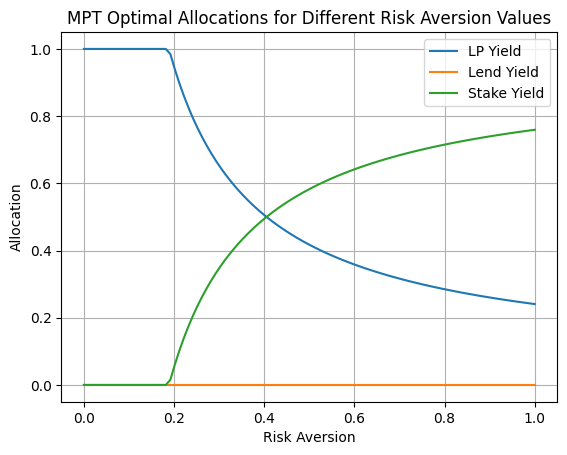

In [98]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
sharpe_ratios = np.array([sharpe_ratio_lp, sharpe_ratio_lend, sharpe_ratio_stake])
average_apy = np.array([average_apy_lp, average_apy_lend, average_apy_stake])
std_devs = np.array([volatility_lp, volatility_lend, volatility_stake])

# Number of assets
num_assets = len(sharpe_ratios)

# Range of risk aversion values
risk_aversion_values = np.linspace(0, 1, 100)

# Empty arrays to store optimal allocations
optimal_allocations = np.zeros((len(risk_aversion_values), num_assets))

# Solve optimization problem for different risk aversion values
for i, risk_aversion in enumerate(risk_aversion_values):
    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal weights
    optimal_allocations[i] = weights.value

# Plot the allocations for different risk aversion values
plt.plot(risk_aversion_values, optimal_allocations[:, 0], label='LP Yield')
plt.plot(risk_aversion_values, optimal_allocations[:, 1], label='Lend Yield')
plt.plot(risk_aversion_values, optimal_allocations[:, 2], label='Stake Yield')
plt.xlabel('Risk Aversion')
plt.ylabel('Allocation')
plt.title('MPT Optimal Allocations for Different Risk Aversion Values')
plt.legend()
plt.grid(True)
plt.show()


Portfolio Return for Risk = 0.5 : 0.0786290361898778


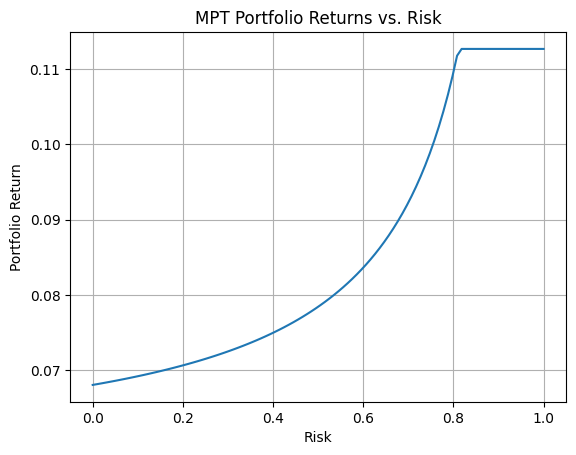

In [99]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
sharpe_ratios = np.array([sharpe_ratio_lp, sharpe_ratio_lend, sharpe_ratio_stake])
average_apy = np.array([average_apy_lp, average_apy_lend, average_apy_stake])
std_devs = np.array([volatility_lp, volatility_lend, volatility_stake])

# Number of assets
num_assets = len(sharpe_ratios)

# Range of risk aversion values
risk_aversion_values = np.linspace(0, 1, 100)

# Empty arrays to store optimal allocations and returns
optimal_allocations = np.zeros((len(risk_aversion_values), num_assets))
portfolio_returns = []

# Solve optimization problem for different risk aversion values
for i, risk_aversion in enumerate(risk_aversion_values):
    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal weights
    optimal_allocations[i] = weights.value

    # Calculate the portfolio return based on the optimal allocation
    portfolio_return = np.dot(weights.value, average_apy)
    portfolio_returns.append(portfolio_return)

# Find the index closest to the desired risk aversion value (e.g., 0.5)
target_risk_aversion = 0.5
closest_index = np.argmin(np.abs(risk_aversion_values - target_risk_aversion))

# Get the portfolio return for the desired risk aversion value
portfolio_return_for_target_risk = portfolio_returns[closest_index]

print("Portfolio Return for Risk =", target_risk_aversion, ":", portfolio_return_for_target_risk)


# Plot the portfolio returns against the flipped risk aversion values
plt.plot(risk_aversion_values[::-1], portfolio_returns)
plt.xlabel('Risk')
plt.ylabel('Portfolio Return')
plt.title('MPT Portfolio Returns vs. Risk')
plt.grid(True)
plt.show()

#### Dynamic Baseline

Best Rebalancing Period: 30 days
Best APY: 7.54%
Best Portfolio Percentage Growth: 3.69%


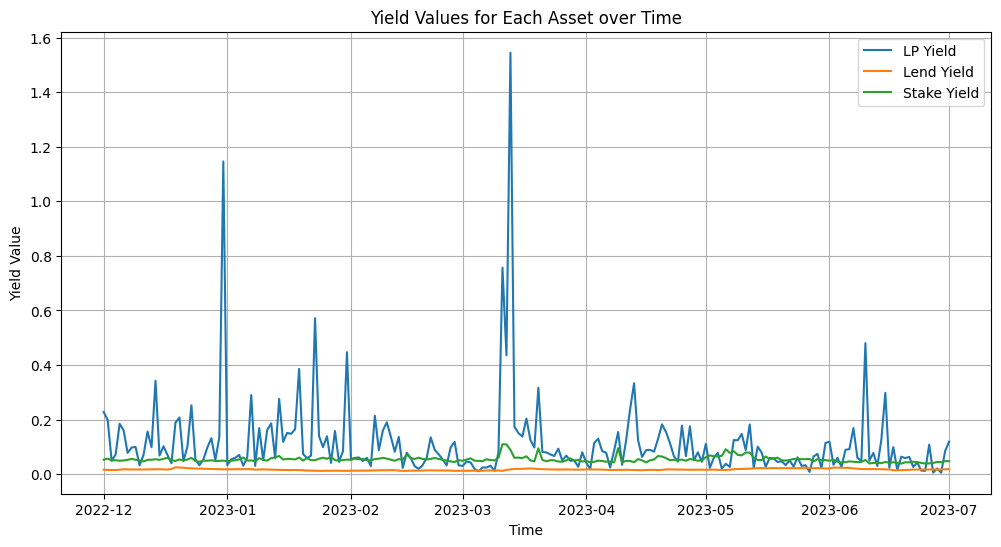

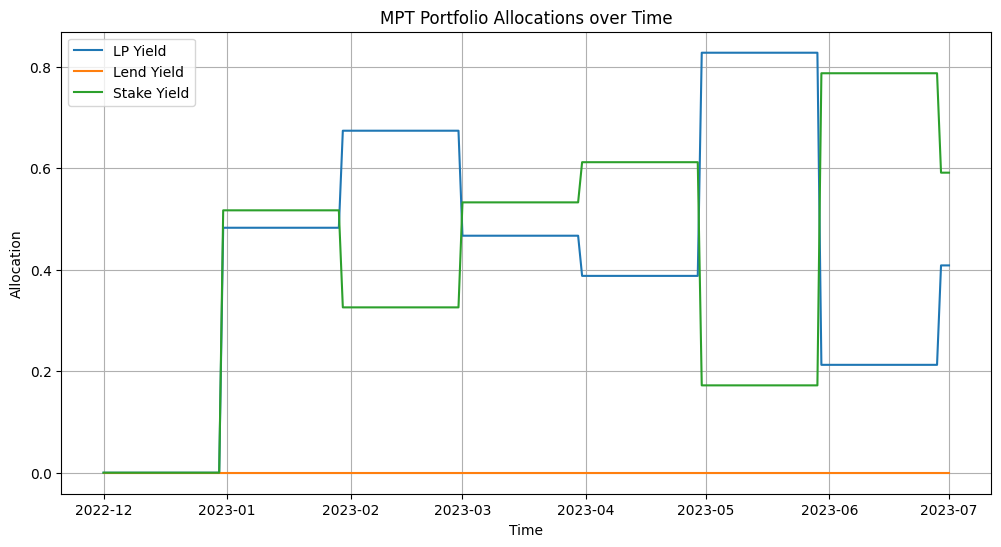

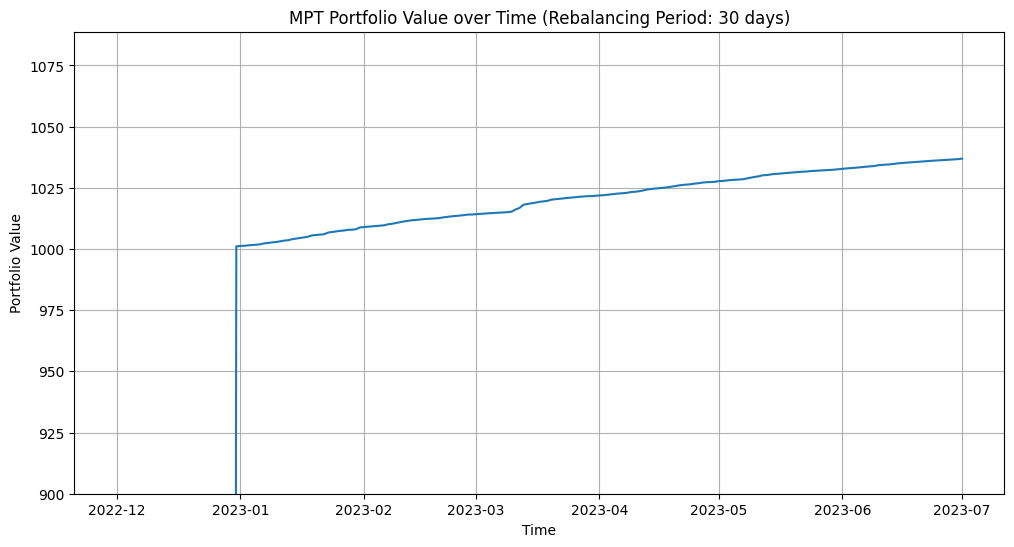

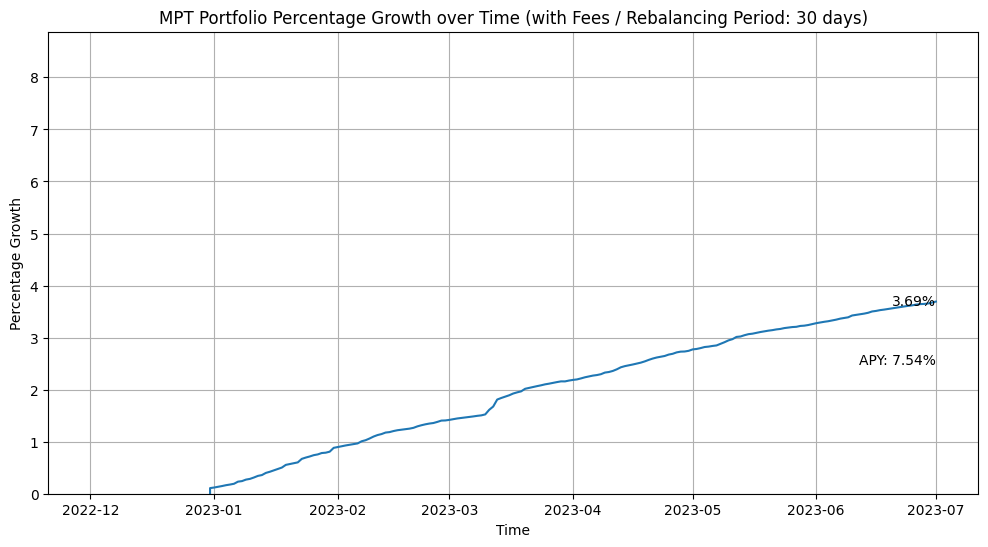

In [100]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 30  # Number of previous time steps to consider for efficient frontier
num_assets = 3  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('mpt_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize variables to track the best rebalancing period and performance
best_rebalancing_period = None
best_apy = -float('inf')
best_portfolio_growth = -float('inf')

# Iterate through different rebalancing periods
for rebalancing_period in range(1, 31):
    portfolio_allocations = np.zeros((len(merged_df), num_assets))
    portfolio_values = np.zeros(len(merged_df))
    initial_investment = 1000  # Initial investment amount

    # Iterate through the data to calculate allocations and track portfolio performance
    for i in range(window_size, len(merged_df)):
        if i % rebalancing_period == 0:
        # Select the data for the previous window_size time steps
            prev_data = merged_df.iloc[i-window_size+1:i+1]

        # Extract the average APYs and standard deviations
            average_apy = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].mean().values
            std_devs = prev_data[['lp_yield', 'lend_yield', 'stake_yield']].std().values

        # Define the variable for weights
            weights = cp.Variable(num_assets)

        # Define the expected return and risk
            expected_return = cp.sum(weights * average_apy)
            risk = cp.quad_form(weights, np.diag(std_devs))

        # Define the objective to maximize the utility function
            objective = cp.Maximize(expected_return - risk_aversion * risk)

        # Define the constraints - sum of weights equal to 1 and weights >= 0
            constraints = [cp.sum(weights) == 1, weights >= 0]

        # Solve the optimization problem
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # Store the optimal allocation for the current time step
            portfolio_allocations[i] = weights.value

        else:
            # Carry forward the previous allocation for non-rebalancing days
            portfolio_allocations[i] = portfolio_allocations[i-1]

        # Calculate the portfolio value based on the allocation and annualized APYs
        allocation = portfolio_allocations[i]
        annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
        
        # Calculate gas fee only on rebalance days
        if (i + 1) % rebalancing_period == 0:
            gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
        else:
            gas_fee = 0
        
        daily_returns = (1 + annualized_apy) ** (1/365) - 1

        # Calculate the portfolio return for the current time step
        adjusted_daily_returns = daily_returns - 2 * gas_fee
        portfolio_return = np.dot(allocation, adjusted_daily_returns)

        # Calculate the portfolio value by compounding the returns
        if i == window_size:
            portfolio_values[i] = initial_investment * (1 + portfolio_return)
        else:
            portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

      # Calculate the percentage growth of the portfolio for the best rebalancing period
    portfolio_percentage_growth = ((portfolio_values - initial_investment) / initial_investment) * 100
               
    # Calculate the APY for the given portfolio growth
    num_days = len(merged_df)-31
    apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

    # Compare APY and portfolio growth with the best values
    if apy > best_apy:
        best_apy = apy
        best_rebalancing_period = rebalancing_period
        best_portfolio_growth = (portfolio_values[-1] - initial_investment) / initial_investment * 100
        best_portfolio_allocations = portfolio_allocations.copy()


# Print the best rebalancing period and performance metrics
print(f"Best Rebalancing Period: {best_rebalancing_period} days")
print(f"Best APY: {best_apy:.2%}")
print(f"Best Portfolio Percentage Growth: {best_portfolio_growth:.2f}%")

# Plot the yield values for each asset over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], merged_df['lp_yield'], label='LP Yield')
plt.plot(merged_df['block_day'], merged_df['lend_yield'], label='Lend Yield')
plt.plot(merged_df['block_day'], merged_df['stake_yield'], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Yield Value')
plt.title('Yield Values for Each Asset over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio allocations over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 0], label='LP Yield')
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 1], label='Lend Yield')
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 2], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title('MPT Portfolio Allocations over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for the best rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title(f'MPT Portfolio Value over Time (Rebalancing Period: {best_rebalancing_period} days)')
plt.ylim(bottom=initial_investment * 0.9)  # Set the lower y-axis limit to 90% of the initial investment
plt.grid(True)
plt.show()

# Plot the percentage growth of the portfolio for the best rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_percentage_growth)
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title(f'MPT Portfolio Percentage Growth over Time (with Fees / Rebalancing Period: {best_rebalancing_period} days)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1], f'{best_portfolio_growth:.2f}%',
         ha='right', va='center')

# Print the APY for the given portfolio growth
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 1, f'APY: {best_apy:.2%}', ha='right', va='top')

plt.show()


### ML Training and Evaluation

In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load the DataFrame with added columns
merged_df = pd.read_csv('ml_training_dataset.csv')

# Select input features and target variables
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']
target_columns = ['lp_allocation', 'lend_allocation', 'stake_allocation']

# Split the data into input features (X) and target variables (y)
X = merged_df[input_features]
y = merged_df[target_columns]

# Initialize the models
linear_reg_model = LinearRegression()
random_forest_model = RandomForestRegressor()
# gradient_boosting_model = GradientBoostingRegressor()

# Train the models
linear_reg_model.fit(X, y)
random_forest_model.fit(X, y)
# gradient_boosting_model.fit(X, y)


RandomForestRegressor()

Since we have 3 separate allocations we treat as targets, this might be reffered to as a multi-output regression problem.

Models, such as linear_reg_model and random_forest_model, are each predicting a vector of three values for each input sample. Behind the scenes, these models handle each target variable separately and make independent predictions for each. This means that the models will not automatically consider the relationships between the three target variables when making predictions.

For predicting multiple target variables simultaneously, you might consider using specialized techniques like Multi-Output Regression or Multi-Task Learning algorithms. These methods are designed to handle scenarios where multiple target variables are interrelated and need to be predicted jointly.

In [102]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
multioutput_rf_model = MultiOutputRegressor(RandomForestRegressor())

# Train the model
multioutput_rf_model.fit(X, y)

MultiOutputRegressor(estimator=RandomForestRegressor())

Now we can predict the allocation using the models, calulate the return of each and comapre.

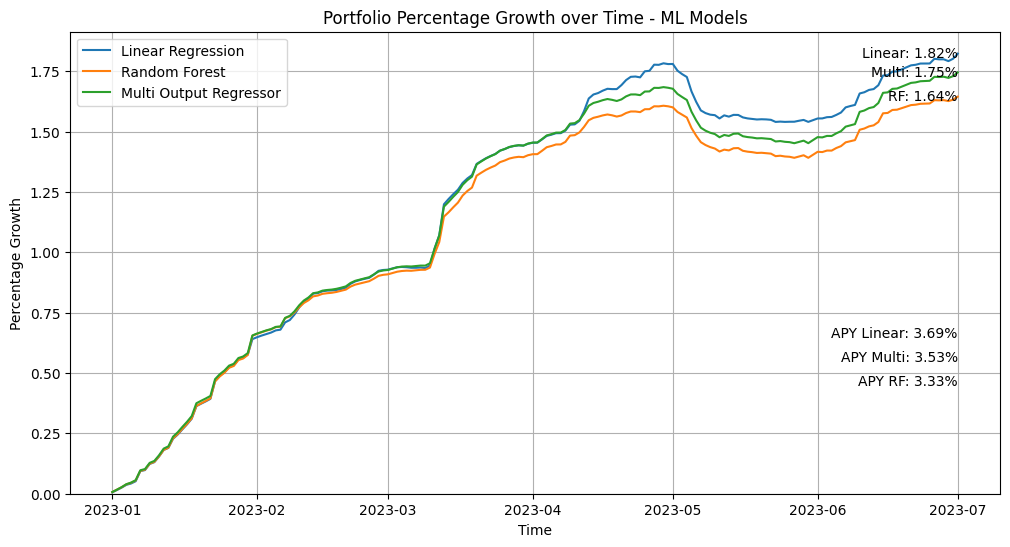

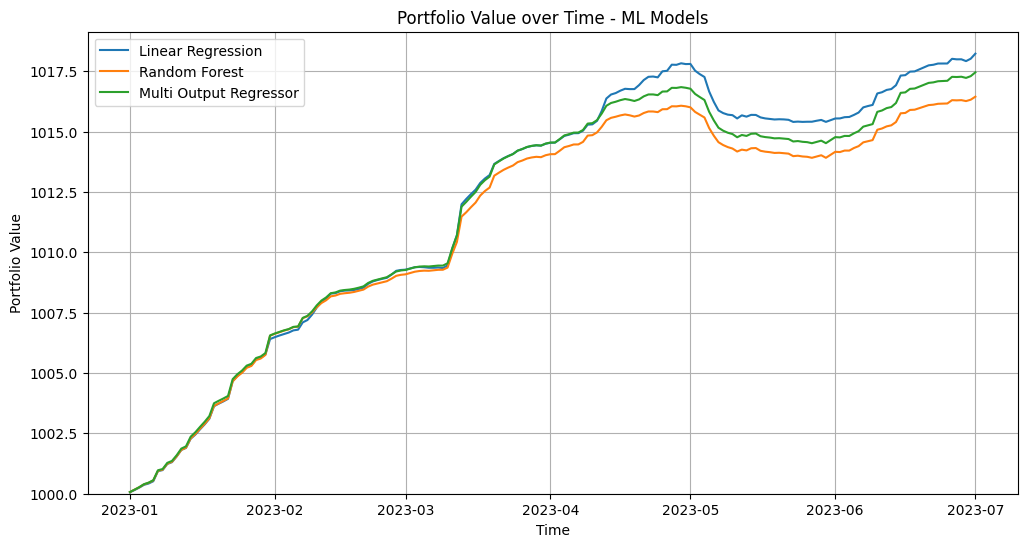

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the new test dataset without allocation columns
new_test_df = pd.read_csv('ml_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
new_test_df['block_day'] = pd.to_datetime(new_test_df['block_day'])

# Select input features
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']

# Predicted allocations using the trained ML models
predicted_allocations_linear = linear_reg_model.predict(new_test_df[input_features])
predicted_allocations_rf = random_forest_model.predict(new_test_df[input_features])
predicted_allocations_multi = multioutput_rf_model.predict(new_test_df[input_features])

# Initialize portfolio values for each model
portfolio_values_linear = np.zeros(len(new_test_df))
portfolio_values_rf = np.zeros(len(new_test_df))
portfolio_values_multi = np.zeros(len(new_test_df))
initial_investment = 1000  # Initial investment amount

for i in range(len(new_test_df)):
    # Calculate the portfolio return for each model
    allocation_linear = predicted_allocations_linear[i]
    allocation_rf = predicted_allocations_rf[i]
    allocation_multi = predicted_allocations_multi[i]
    
    annualized_apy = new_test_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    gas_fee = new_test_df.iloc[i]['fee_usd']  # Gas fee in USD
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate the daily portfolio return adjusted for gas fees
    adjusted_daily_returns = daily_returns - 2 * gas_fee
    portfolio_return_linear = np.dot(allocation_linear, adjusted_daily_returns)
    portfolio_return_rf = np.dot(allocation_rf, adjusted_daily_returns)
    portfolio_return_multi = np.dot(allocation_multi, adjusted_daily_returns)
    
    if i == 0:
        portfolio_values_linear[i] = initial_investment * (1 + portfolio_return_linear)
        portfolio_values_rf[i] = initial_investment * (1 + portfolio_return_rf)
        portfolio_values_multi[i] = initial_investment * (1 + portfolio_return_multi)
    else:
        portfolio_values_linear[i] = portfolio_values_linear[i-1] * (1 + portfolio_return_linear)
        portfolio_values_rf[i] = portfolio_values_rf[i-1] * (1 + portfolio_return_rf)
        portfolio_values_multi[i] = portfolio_values_multi[i-1] * (1 + portfolio_return_multi)

# Calculate the percentage growth of the portfolios
portfolio_percentage_growth_linear = (portfolio_values_linear - initial_investment) / initial_investment * 100
portfolio_percentage_growth_rf = (portfolio_values_rf - initial_investment) / initial_investment * 100
portfolio_percentage_growth_multi = (portfolio_values_multi - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(new_test_df)
apy_linear = (portfolio_values_linear[-1] / initial_investment) ** (365 / num_days) - 1
apy_rf = (portfolio_values_rf[-1] / initial_investment) ** (365 / num_days) - 1
apy_multi = (portfolio_values_multi[-1] / initial_investment) ** (365 / num_days) - 1

# Plot the portfolio value over time for each model
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_linear, label='Linear Regression')
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_rf, label='Random Forest')
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_multi, label='Multi Output Regressor')

# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Portfolio Percentage Growth over Time - ML Models')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.legend()
plt.grid(True)
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_linear[-1], f'Linear: {portfolio_percentage_growth_linear[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_rf[-1], f'RF: {portfolio_percentage_growth_rf[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_multi[-1], f'Multi: {portfolio_percentage_growth_multi[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3, f'APY Linear: {apy_linear:.2%}', ha='right', va='top')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3.1, f'APY Multi: {apy_multi:.2%}', ha='right', va='top')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3.2, f'APY RF: {apy_rf:.2%}', ha='right', va='top')

plt.show()

# Print the APY for the given portfolio growth
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_values_linear, label='Linear Regression')
plt.plot(new_test_df['block_day'], portfolio_values_rf, label='Random Forest')
plt.plot(new_test_df['block_day'], portfolio_values_multi, label='Multi Output Regressor')
# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# # Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Time - ML Models')
plt.ylim(bottom=1000)  # Set the lower y-axis limit to 90% of the initial investment
plt.legend()
plt.grid(True)
plt.show()


That was daily returns, but if we apply the optimal 30 day rebalancing period:

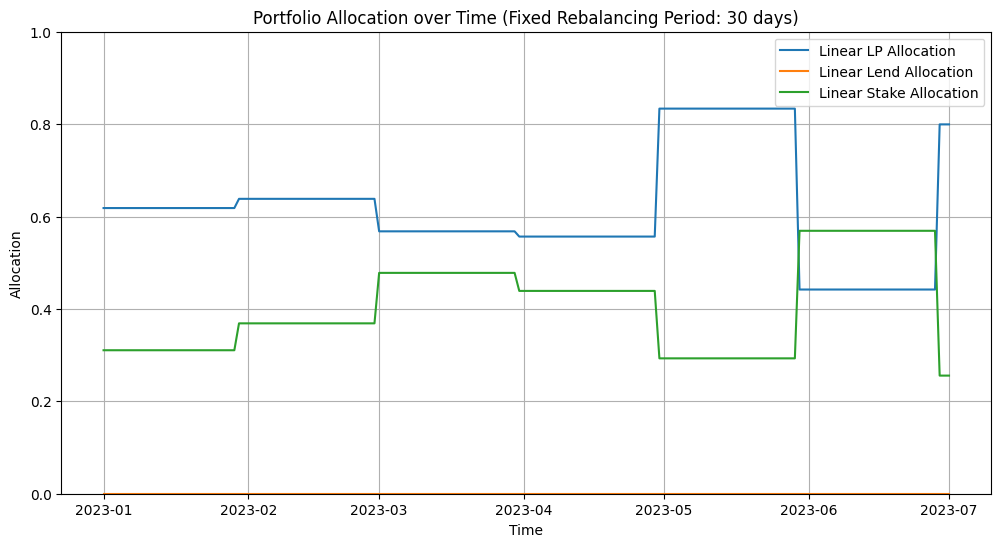

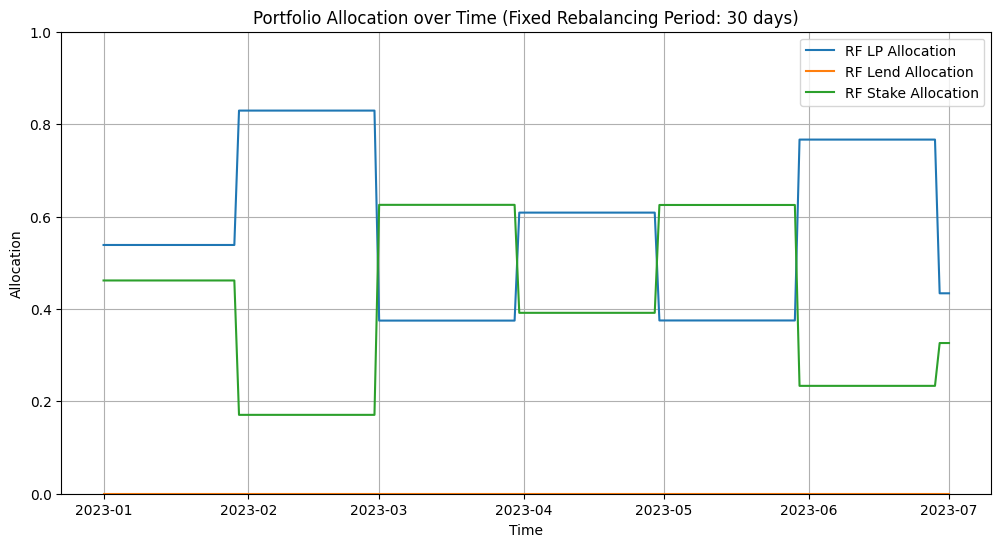

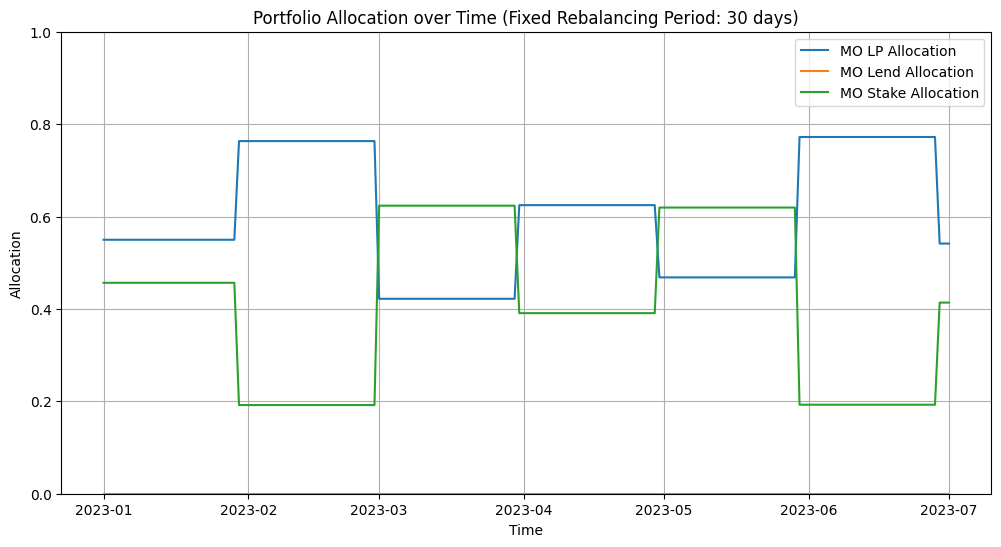

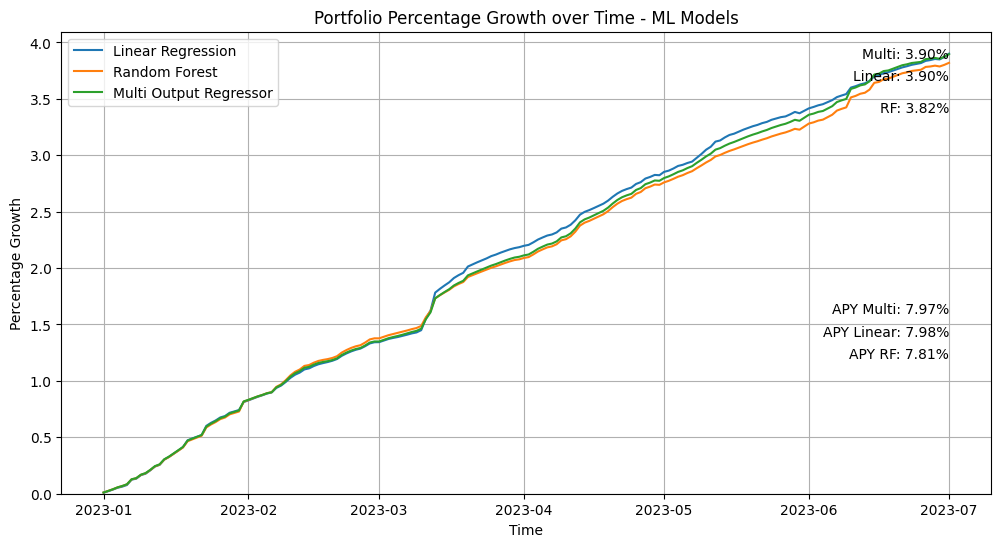

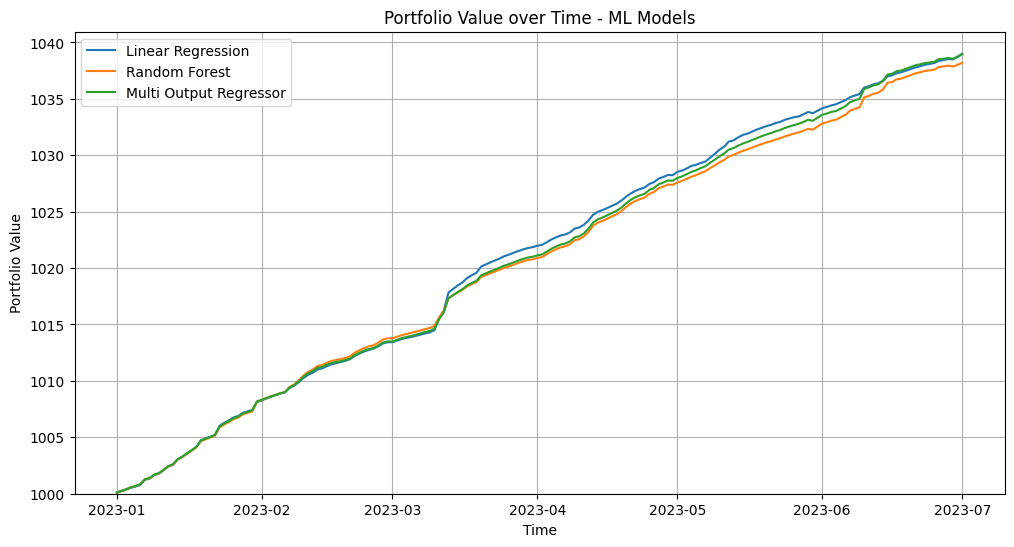

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the new test dataset without allocation columns
new_test_df = pd.read_csv('ml_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
new_test_df['block_day'] = pd.to_datetime(new_test_df['block_day'])

# Select input features
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']

# Predicted allocations using the trained ML models
predicted_allocations_linear = linear_reg_model.predict(new_test_df[input_features])
predicted_allocations_rf = random_forest_model.predict(new_test_df[input_features])
predicted_allocations_multi = multioutput_rf_model.predict(new_test_df[input_features])

# Initialize portfolio values for each model
portfolio_values_linear = np.zeros(len(new_test_df))
portfolio_values_rf = np.zeros(len(new_test_df))
portfolio_values_multi = np.zeros(len(new_test_df))
initial_investment = 1000  # Initial investment amount

rebalancing_period = 30  # Rebalance every 30 days
current_allocation_linear = predicted_allocations_linear[0]
current_allocation_rf = predicted_allocations_rf[0]
current_allocation_multi = predicted_allocations_multi[0]

# Initialize portfolio allocations for each model
portfolio_allocations_linear = np.zeros((len(new_test_df), num_assets))
portfolio_allocations_rf = np.zeros((len(new_test_df), num_assets))
portfolio_allocations_multi = np.zeros((len(new_test_df), num_assets))

for i in range(len(new_test_df)):
    # Calculate the portfolio return for each model
    annualized_apy = new_test_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate the daily portfolio return adjusted for gas fees only on rebalance days
    if (i + 1) % rebalancing_period == 0:
        gas_fee = new_test_df.iloc[i]['fee_usd']  # Gas fee in USD
        adjusted_daily_returns = daily_returns - 2 * gas_fee
    else:
        adjusted_daily_returns = daily_returns
    
    portfolio_return_linear = np.dot(current_allocation_linear, adjusted_daily_returns)
    portfolio_return_rf = np.dot(current_allocation_rf, adjusted_daily_returns)
    portfolio_return_multi = np.dot(current_allocation_multi, adjusted_daily_returns)
    
    if i == 0:
        portfolio_values_linear[i] = initial_investment * (1 + portfolio_return_linear)
        portfolio_values_rf[i] = initial_investment * (1 + portfolio_return_rf)
        portfolio_values_multi[i] = initial_investment * (1 + portfolio_return_multi)
    else:
        portfolio_values_linear[i] = portfolio_values_linear[i-1] * (1 + portfolio_return_linear)
        portfolio_values_rf[i] = portfolio_values_rf[i-1] * (1 + portfolio_return_rf)
        portfolio_values_multi[i] = portfolio_values_multi[i-1] * (1 + portfolio_return_multi)
    
    # Rebalance every 5 days
    if (i + 1) % rebalancing_period == 0:
        current_allocation_linear = predicted_allocations_linear[i]
        current_allocation_rf = predicted_allocations_rf[i]
        current_allocation_multi = predicted_allocations_multi[i]

    # Store the allocations for the current time step
    portfolio_allocations_linear[i] = current_allocation_linear
    portfolio_allocations_rf[i] = current_allocation_rf
    portfolio_allocations_multi[i] = current_allocation_multi

# Calculate the percentage growth of the portfolios
portfolio_percentage_growth_linear = (portfolio_values_linear - initial_investment) / initial_investment * 100
portfolio_percentage_growth_rf = (portfolio_values_rf - initial_investment) / initial_investment * 100
portfolio_percentage_growth_multi = (portfolio_values_multi - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(new_test_df)
apy_linear = (portfolio_values_linear[-1] / initial_investment) ** (365 / num_days) - 1
apy_rf = (portfolio_values_rf[-1] / initial_investment) ** (365 / num_days) - 1
apy_multi = (portfolio_values_multi[-1] / initial_investment) ** (365 / num_days) - 1

# Plot the portfolio allocation over time for the fixed rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_linear[:, 0], label='Linear LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_linear[:, 1], label='Linear Lend Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_linear[:, 2], label='Linear Stake Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_rf[:, 0], label='RF LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_rf[:, 1], label='RF Lend Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_rf[:, 2], label='RF Stake Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 0], label='MO LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 1], label='MO Lend Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 2], label='MO Stake Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for each model
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_linear, label='Linear Regression')
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_rf, label='Random Forest')
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_multi, label='Multi Output Regressor')
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Portfolio Percentage Growth over Time - ML Models')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.legend()
plt.grid(True)
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_linear[-1]-0.2, f'Linear: {portfolio_percentage_growth_linear[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_rf[-1]-0.4, f'RF: {portfolio_percentage_growth_rf[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_multi[-1], f'Multi: {portfolio_percentage_growth_multi[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] -2.2, f'APY Linear: {apy_linear:.2%}', ha='right', va='top')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2.4, f'APY RF: {apy_rf:.2%}', ha='right', va='top')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2, f'APY Multi: {apy_multi:.2%}', ha='right', va='top')
plt.show()

# Print the APY for the given portfolio growth
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_values_linear, label='Linear Regression')
plt.plot(new_test_df['block_day'], portfolio_values_rf, label='Random Forest')
plt.plot(new_test_df['block_day'], portfolio_values_multi, label='Multi Output Regressor')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Time - ML Models')
plt.ylim(bottom=1000)  # Set the lower y-axis limit to 90% of the initial investment
plt.legend()
plt.grid(True)
plt.show()


The Multi Output Regressor being suited for a problem with several target variables, outperformed all other methods slightly. We could probably use it as is, but lets see what happens when we tune the Multi Output Regressor further, by treating each output target (in your case, each allocation type) as a separate target variable, training a separate Random Forest for each target and then wrapping it in a Multi Output Regressor.

Note that all three models however, despite not being tuned, performed better than out MPT benchmark.

In [107]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest hyperparameters
rf_param_grid = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 5, 10]}

# Tune the Random Forest for each output
best_rf_models = {}
for target_column in target_columns:
    rf_model = RandomForestRegressor()
    rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5)
    rf_grid.fit(X, y[target_column])
    best_rf_models[target_column] = rf_grid.best_estimator_
    print(f"Best Random Forest Hyperparameters for {target_column}:", rf_grid.best_params_)

# Define the parameter grid for MultiOutputRegressor hyperparameters
multi_param_grid = {'estimator': [best_rf_models['lp_allocation'], 
                                  best_rf_models['lend_allocation'], 
                                  best_rf_models['stake_allocation']],
                    'n_jobs': [-1, 1]}  # Use all CPU cores or single core

# Tune the MultiOutputRegressor
multi_rf_model = MultiOutputRegressor(RandomForestRegressor())
multi_grid = GridSearchCV(multi_rf_model, multi_param_grid, cv=5)
multi_grid.fit(X, y)
best_multi_model = multi_grid.best_estimator_
print("Best MultiOutputRegressor Hyperparameters:", multi_grid.best_params_)

Best Random Forest Hyperparameters for lp_allocation: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest Hyperparameters for lend_allocation: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 150}
Best Random Forest Hyperparameters for stake_allocation: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best MultiOutputRegressor Hyperparameters: {'estimator': RandomForestRegressor(max_depth=20), 'n_jobs': 1}


After obtaining the best parameters, let's retrain the Multi Output model and see the impact on the results in terms of portfolio returns when compared to the Linear Regression.

In [108]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Train the MultiOutputRegressor with the best parameters
best_multi_model = MultiOutputRegressor(RandomForestRegressor(max_depth=20, n_estimators=50), n_jobs=1)
best_multi_model.fit(X, y)


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     n_estimators=50),
                     n_jobs=1)

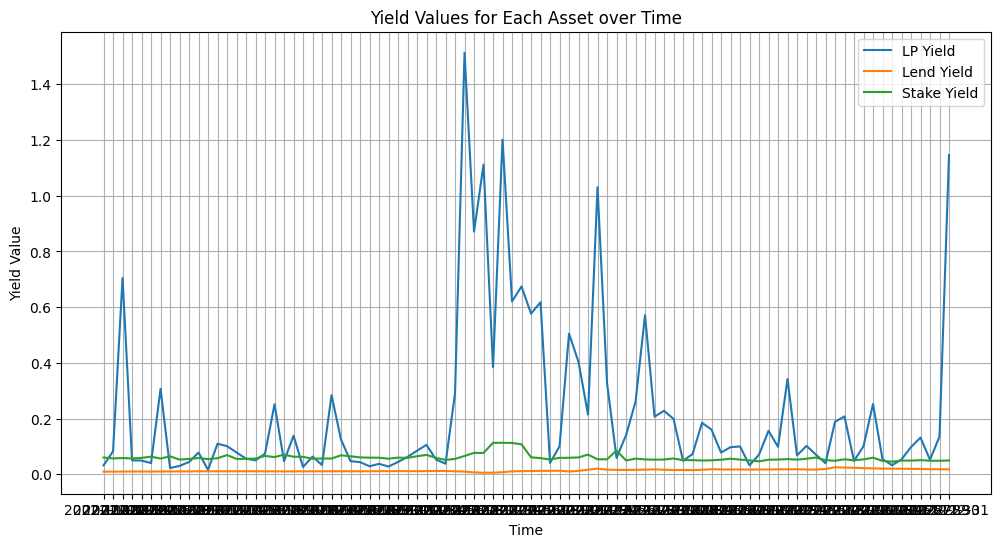

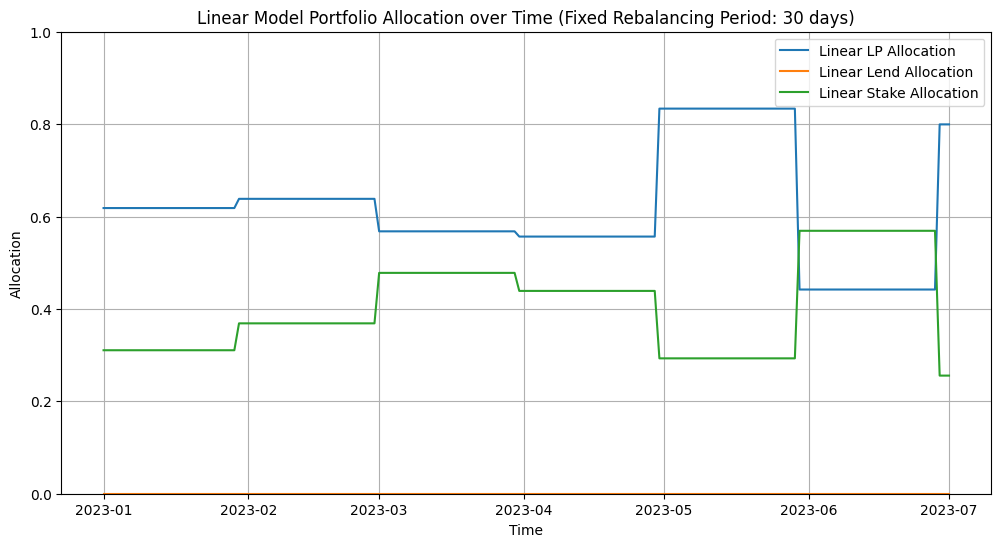

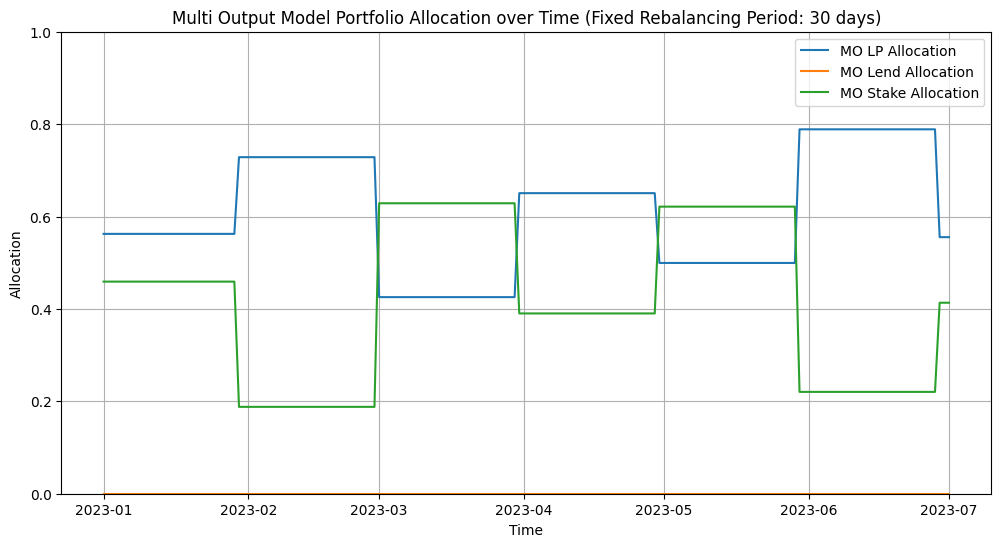

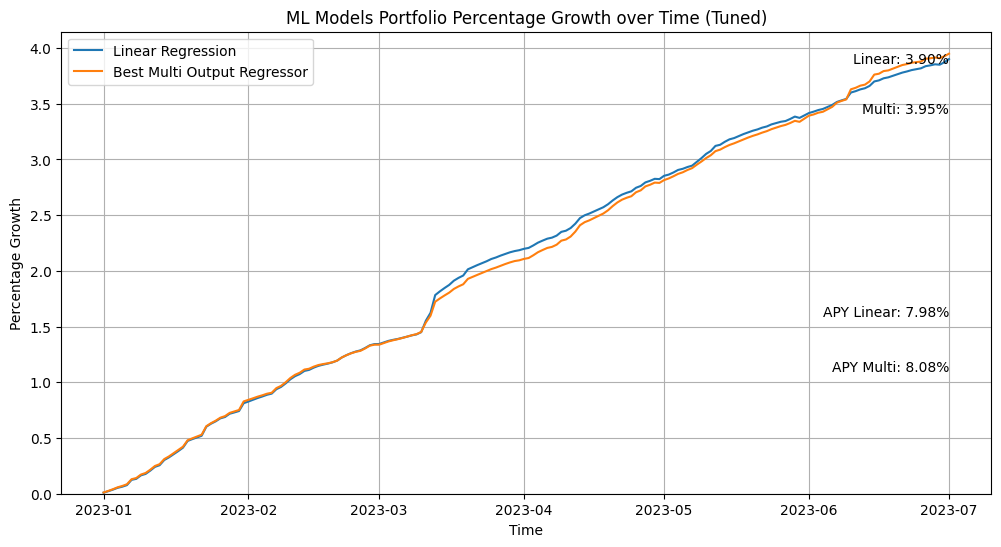

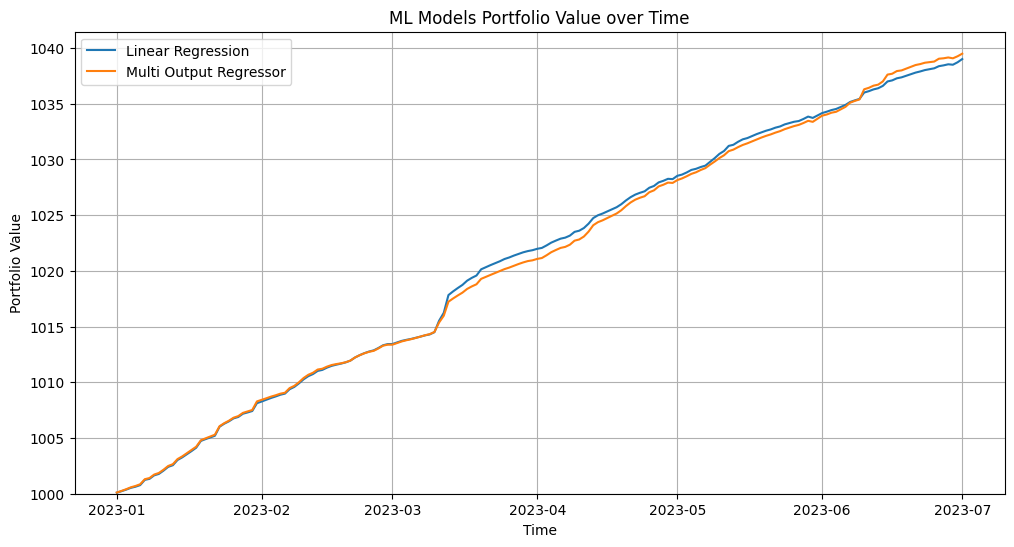

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the new test dataset without allocation columns
new_test_df = pd.read_csv('ml_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
new_test_df['block_day'] = pd.to_datetime(new_test_df['block_day'])

# Select input features
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']

# Predicted allocations using the trained ML models
predicted_allocations_linear = linear_reg_model.predict(new_test_df[input_features])
predicted_allocations_multi = best_multi_model.predict(new_test_df[input_features])

# Initialize portfolio values for each model
portfolio_values_linear = np.zeros(len(new_test_df))
portfolio_values_multi = np.zeros(len(new_test_df))
initial_investment = 1000  # Initial investment amount

rebalancing_period = 30  # Rebalance every 15 days
current_allocation_linear = predicted_allocations_linear[0]
current_allocation_multi = predicted_allocations_multi[0]

# Initialize portfolio allocations for each model
portfolio_allocations_linear = np.zeros((len(new_test_df), num_assets))
portfolio_allocations_multi = np.zeros((len(new_test_df), num_assets))

for i in range(len(new_test_df)):
    # Calculate the portfolio return for each model
    annualized_apy = new_test_df.iloc[i][['lp_yield', 'lend_yield', 'stake_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate the daily portfolio return adjusted for gas fees only on rebalance days
    if (i + 1) % rebalancing_period == 0:
        gas_fee = new_test_df.iloc[i]['fee_usd']  # Gas fee in USD
        adjusted_daily_returns = daily_returns - 2 * gas_fee
    else:
        adjusted_daily_returns = daily_returns
    
    portfolio_return_linear = np.dot(current_allocation_linear, adjusted_daily_returns)
    portfolio_return_multi = np.dot(current_allocation_multi, adjusted_daily_returns)
    
    if i == 0:
        portfolio_values_linear[i] = initial_investment * (1 + portfolio_return_linear)
        portfolio_values_multi[i] = initial_investment * (1 + portfolio_return_multi)
    else:
        portfolio_values_linear[i] = portfolio_values_linear[i-1] * (1 + portfolio_return_linear)
        portfolio_values_multi[i] = portfolio_values_multi[i-1] * (1 + portfolio_return_multi)
    
    # Rebalance every 5 days
    if (i + 1) % rebalancing_period == 0:
        current_allocation_linear = predicted_allocations_linear[i]
        current_allocation_multi = predicted_allocations_multi[i]

    # Store the allocations for the current time step
    portfolio_allocations_linear[i] = current_allocation_linear
    portfolio_allocations_multi[i] = current_allocation_multi

# Calculate the percentage growth of the portfolios
portfolio_percentage_growth_linear = (portfolio_values_linear - initial_investment) / initial_investment * 100
portfolio_percentage_growth_multi = (portfolio_values_multi - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(new_test_df)
apy_linear = (portfolio_values_linear[-1] / initial_investment) ** (365 / num_days) - 1
apy_multi = (portfolio_values_multi[-1] / initial_investment) ** (365 / num_days) - 1

# Plot the yield values for each asset over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], merged_df['lp_yield'], label='LP Yield')
plt.plot(merged_df['block_day'], merged_df['lend_yield'], label='Lend Yield')
plt.plot(merged_df['block_day'], merged_df['stake_yield'], label='Stake Yield')
plt.xlabel('Time')
plt.ylabel('Yield Value')
plt.title('Yield Values for Each Asset over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio allocation over time for the fixed rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_linear[:, 0], label='Linear LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_linear[:, 1], label='Linear Lend Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_linear[:, 2], label='Linear Stake Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Linear Model Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 0], label='MO LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 1], label='MO Lend Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 2], label='MO Stake Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Multi Output Model Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for each model
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_linear, label='Linear Regression')
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_multi, label='Best Multi Output Regressor')

# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('ML Models Portfolio Percentage Growth over Time (Tuned)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.legend()
plt.grid(True)
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_linear[-1], f'Linear: {portfolio_percentage_growth_linear[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_multi[-1]-0.5, f'Multi: {portfolio_percentage_growth_multi[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2, f'APY Linear: {apy_linear:.2%}', ha='right', va='top')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2.5, f'APY Multi: {apy_multi:.2%}', ha='right', va='top')
plt.show()

# Print the APY for the given portfolio growth
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_values_linear, label='Linear Regression')
plt.plot(new_test_df['block_day'], portfolio_values_multi, label='Multi Output Regressor')
# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# # Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('ML Models Portfolio Value over Time')
plt.ylim(bottom=1000)  # Set the lower y-axis limit to 90% of the initial investment
plt.legend()
plt.grid(True)
plt.show()


Further tuning cemented the superior performance of the MO Model, and even if the outcome is simmilar now, choosing the Multi OUtput Model might be better long-term due to the nature of the model abd being more fit for purpose. 

More over, when we look at the behavior of the models in deciding about allocation, we can see how differently they react to the changes in yield from the 3 sources over time. The Linear Regression model is much more suseptible to the more volatile high0yield LP source> It pretty much always prefer holding that asset, over the other and upon spikes in LP return, it would favor that source even more for longer periods of time.

The Multi Output model seems to be more balanced and less reactive to sudden movements in LP's return, while keeping the same level of return.

For comaprison, the baseline MPT model discouraged the choice of LP yield after the sudden spikes (due to risk aversity), but was less stable with the allocations over time. 

### Solo Staking vs Liquid Staking

The entire analysis above assumed that a "Solo Staking" scenario, in which the user can reap benefits from Staking Yield only if they stake the tokens directly with the network and effectively "lock" them for the entire period. 

In real life however, a lot of assets (ETh and Fantom icnluded) offer what's called "Liquid Staking". This allows your tokens to be delegated, adn locked with a Staker that in return issues a recipet token (staked ETH for Ethereum or staked FTX for Fantom) that can be treated like the orginal asset 1:1, allowing you to still take advatage of the other two yield sources.

In that case, Lending Source which was previously discouraged by both MPT and the ML approach will become more valid and open up new opportunities. In practical terms this will mean taking Stake Yield out of the calcuation and treating it as a "given".

First we can calculate what return "Liquid Staking" will generate for us in the background, while the full sum can still be allocated elsewhere.

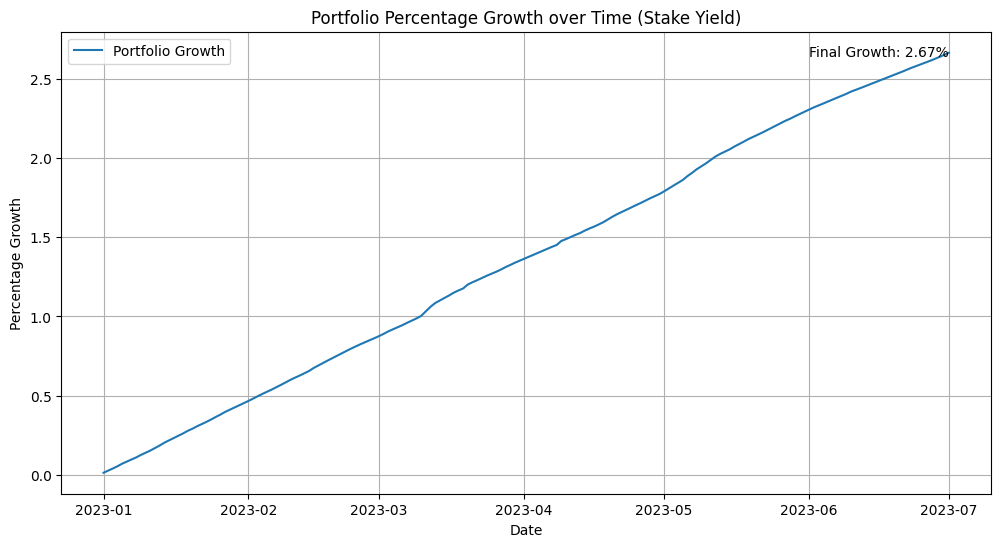

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('mpt_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
df['block_day'] = pd.to_datetime(df['block_day'])

# Filter data from the start date
start_date = pd.Timestamp("2023-01-01")
df = df[df['block_day'] >= start_date]

zeros = np.zeros(31)
zeros_df = pd.DataFrame({'percentage_growth': zeros})

# Concatenate the zeros DataFrame with the existing DataFrame
df = pd.concat([zeros_df, df], ignore_index=True)

# Convert annualized yield to daily yield
df['daily_returns'] = ((1 + df['stake_yield']) ** (1/365) - 1)

# Calculate cumulative returns for the portfolio
df['cumulative_returns'] = (1 + df['daily_returns']).cumprod()

# Calculate the percentage growth of the portfolio
initial_investment = 1000
df['percentage_growth'] = (df['cumulative_returns'] - 1) * 100

final_percentage_growth = df['percentage_growth'].iloc[-1]

# Calculate APY for the given portfolio growth
num_days = len(df)

# Plot the percentage growth of the portfolio
plt.figure(figsize=(12, 6))
plt.plot(df['block_day'], df['percentage_growth'], label='Portfolio Growth')
plt.xlabel('Date')
plt.ylabel('Percentage Growth')
plt.title('Portfolio Percentage Growth over Time (Stake Yield)')
plt.grid(True)

# Display APY and final percentage growth on the graph
plt.text(df['block_day'].values[-1], final_percentage_growth, f'Final Growth: {final_percentage_growth:.2f}%', ha='right', va='center')

plt.legend()
plt.show()

And then we can build a new portfolio woth the other two sources of yield.

In [111]:
import numpy as np
import cvxpy as cp
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

merged_df = pd.read_csv('mpt_evaluation_dataset.csv')

# Convert the 'block_day' column to datetime format (if needed)
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

average_apy = merged_df.mean()

average_apy_lp = average_apy['lp_yield']
average_apy_lend = average_apy['lend_yield']

volatility_lp = merged_df['lp_yield'].std()
volatility_lend = merged_df['lend_yield'].std()

average_apy = np.array([average_apy_lp, average_apy_lend])
std_devs = np.array([volatility_lp, volatility_lend])

# Number of assets
num_assets = len(average_apy )

# Risk aversion factor
risk_aversion = 0.5

# Define the variable for weights
weights = cp.Variable(num_assets)

# Define the expected return and risk
expected_return = cp.sum(weights * average_apy)
risk = cp.quad_form(weights, np.diag(std_devs))

# Define the objective to maximize the utility function
objective = cp.Maximize(expected_return - risk_aversion * risk)

# Define the constraints - sum of weights equal to 1 and weights >= 0
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal weights for the efficient frontier
optimal_weights = weights.value

# Print the optimal weights
for i in range(num_assets):
    print(f"{['LP Yield', 'Lend Yield', 'Stake Yield'][i]}: {optimal_weights[i]}")


LP Yield: 0.622393561621841
Lend Yield: 0.37760643837815905


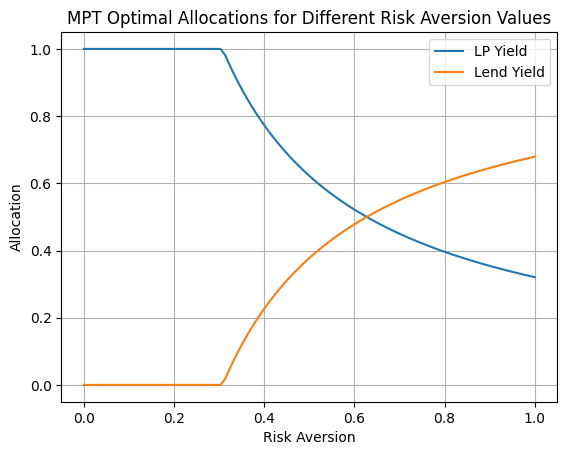

In [112]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
average_apy = np.array([average_apy_lp, average_apy_lend])
std_devs = np.array([volatility_lp, volatility_lend])

# Number of assets
num_assets = len(average_apy)

# Range of risk aversion values
risk_aversion_values = np.linspace(0, 1, 100)

# Empty arrays to store optimal allocations
optimal_allocations = np.zeros((len(risk_aversion_values), num_assets))

# Solve optimization problem for different risk aversion values
for i, risk_aversion in enumerate(risk_aversion_values):
    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal weights
    optimal_allocations[i] = weights.value

# Plot the allocations for different risk aversion values
plt.plot(risk_aversion_values, optimal_allocations[:, 0], label='LP Yield')
plt.plot(risk_aversion_values, optimal_allocations[:, 1], label='Lend Yield')
plt.xlabel('Risk Aversion')
plt.ylabel('Allocation')
plt.title('MPT Optimal Allocations for Different Risk Aversion Values')
plt.legend()
plt.grid(True)
plt.show()


Portfolio Return for Risk = 0.5 : 0.07709705489840298


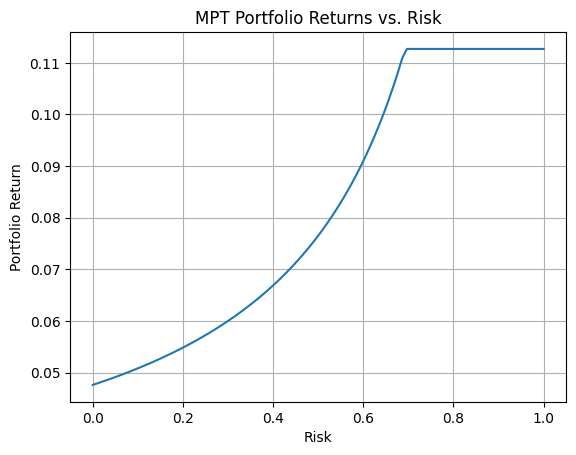

In [113]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given Sharpe Ratios, Average APYs, and Standard Deviations
average_apy = np.array([average_apy_lp, average_apy_lend])
std_devs = np.array([volatility_lp, volatility_lend])

# Number of assets
num_assets = len(average_apy)

# Range of risk aversion values
risk_aversion_values = np.linspace(0, 1, 100)

# Empty arrays to store optimal allocations and returns
optimal_allocations = np.zeros((len(risk_aversion_values), num_assets))
portfolio_returns = []

# Solve optimization problem for different risk aversion values
for i, risk_aversion in enumerate(risk_aversion_values):
    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal weights
    optimal_allocations[i] = weights.value

    # Calculate the portfolio return based on the optimal allocation
    portfolio_return = np.dot(weights.value, average_apy)
    portfolio_returns.append(portfolio_return)

# Find the index closest to the desired risk aversion value (e.g., 0.5)
target_risk_aversion = 0.5
closest_index = np.argmin(np.abs(risk_aversion_values - target_risk_aversion))

# Get the portfolio return for the desired risk aversion value
portfolio_return_for_target_risk = portfolio_returns[closest_index]

print("Portfolio Return for Risk =", target_risk_aversion, ":", portfolio_return_for_target_risk)


# Plot the portfolio returns against the flipped risk aversion values
plt.plot(risk_aversion_values[::-1], portfolio_returns)
plt.xlabel('Risk')
plt.ylabel('Portfolio Return')
plt.title('MPT Portfolio Returns vs. Risk')
plt.grid(True)
plt.show()

Best Rebalancing Period: 30 days
Best APY: 8.51%
Best Portfolio Percentage Growth: 4.16%


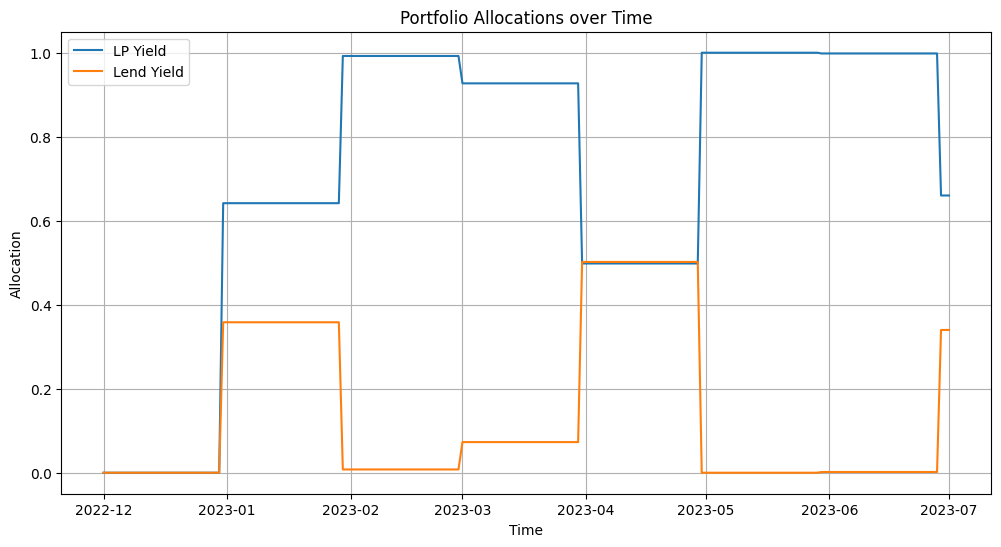

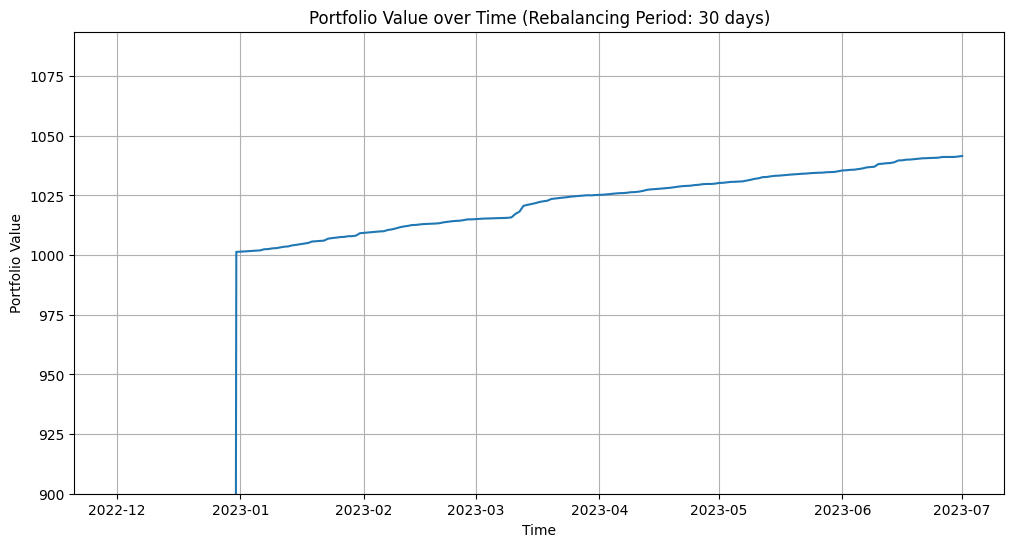

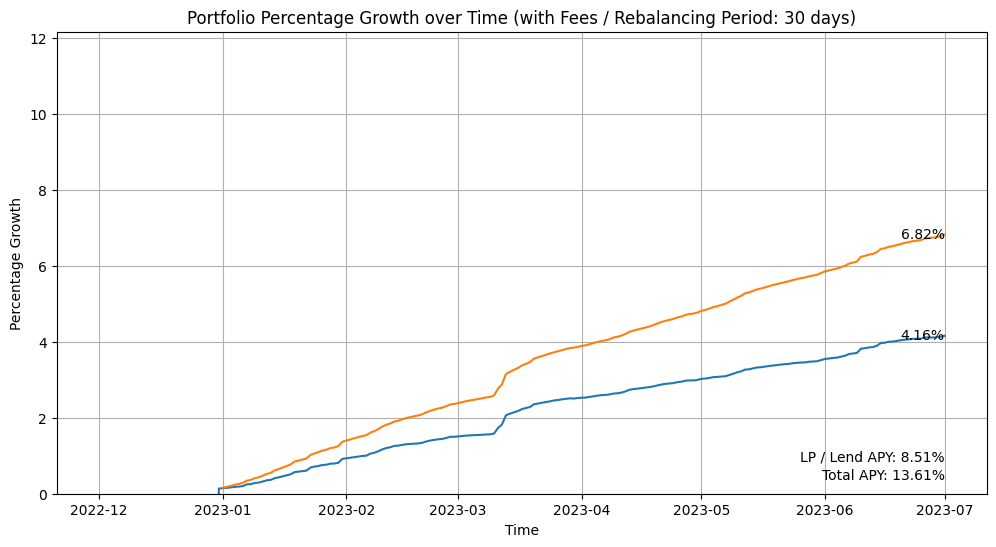

In [114]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Ignore all warnings
warnings.filterwarnings("ignore")

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 30  # Number of previous time steps to consider for efficient frontier
num_assets = 2  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('mpt_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize variables to track the best rebalancing period and performance
best_rebalancing_period = None
best_apy = -float('inf')
best_portfolio_growth = -float('inf')

# Iterate through different rebalancing periods
for rebalancing_period in range(1, 31):
    portfolio_allocations = np.zeros((len(merged_df), num_assets))
    portfolio_values = np.zeros(len(merged_df))
    initial_investment = 1000  # Initial investment amount

    # Iterate through the data to calculate allocations and track portfolio performance
    for i in range(window_size, len(merged_df)):
        if i % rebalancing_period == 0:
        # Select the data for the previous window_size time steps
            prev_data = merged_df.iloc[i-window_size+1:i+1]

        # Extract the average APYs and standard deviations
            average_apy = prev_data[['lp_yield', 'lend_yield']].mean().values
            std_devs = prev_data[['lp_yield', 'lend_yield']].std().values

        # Define the variable for weights
            weights = cp.Variable(num_assets)

        # Define the expected return and risk
            expected_return = cp.sum(weights * average_apy)
            risk = cp.quad_form(weights, np.diag(std_devs))

        # Define the objective to maximize the utility function
            objective = cp.Maximize(expected_return - risk_aversion * risk)

        # Define the constraints - sum of weights equal to 1 and weights >= 0
            constraints = [cp.sum(weights) == 1, weights >= 0]

        # Solve the optimization problem
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # Store the optimal allocation for the current time step
            portfolio_allocations[i] = weights.value

        else:
            # Carry forward the previous allocation for non-rebalancing days
            portfolio_allocations[i] = portfolio_allocations[i-1]

        # Calculate the portfolio value based on the allocation and annualized APYs
        allocation = portfolio_allocations[i]
        annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield']].values
        
        # Calculate gas fee only on rebalance days
        if (i + 1) % rebalancing_period == 0:
            gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
        else:
            gas_fee = 0
        
        daily_returns = (1 + annualized_apy) ** (1/365) - 1

        # Calculate the portfolio return for the current time step
        adjusted_daily_returns = daily_returns - 2 * gas_fee
        portfolio_return = np.dot(allocation, adjusted_daily_returns)

        # Calculate the portfolio value by compounding the returns
        if i == window_size:
            portfolio_values[i] = initial_investment * (1 + portfolio_return)
        else:
            portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

     # Calculate the percentage growth of the portfolio for the best rebalancing period
    portfolio_percentage_growth = ((portfolio_values - initial_investment) / initial_investment) * 100
     
    # Calculate the APY for the given portfolio growth
    num_days = len(merged_df)-31
    apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

    # Compare APY and portfolio growth with the best values
    if apy > best_apy:
        best_apy = apy
        best_rebalancing_period = rebalancing_period
        best_portfolio_growth = (portfolio_values[-1] - initial_investment) / initial_investment * 100
        best_portfolio_allocations = portfolio_allocations.copy()


# Calculate the combined portfolio growth by summing the two growths
combined_portfolio_growth = portfolio_percentage_growth + df['percentage_growth']
combined_apy = (((combined_portfolio_growth[212] / 100)) / 183) * 365

# Print the best rebalancing period and performance metrics
print(f"Best Rebalancing Period: {best_rebalancing_period} days")
print(f"Best APY: {best_apy:.2%}")
print(f"Best Portfolio Percentage Growth: {best_portfolio_growth:.2f}%")

# Plot the portfolio allocations over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 0], label='LP Yield')
plt.plot(merged_df['block_day'], best_portfolio_allocations[:, 1], label='Lend Yield')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title('Portfolio Allocations over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for the best rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_values)
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title(f'Portfolio Value over Time (Rebalancing Period: {best_rebalancing_period} days)')
plt.ylim(bottom=initial_investment * 0.9)  # Set the lower y-axis limit to 90% of the initial investment
plt.grid(True)
plt.show()

# Plot the percentage growth of the portfolio for the best rebalancing period
plt.figure(figsize=(12, 6))
plt.plot(merged_df['block_day'], portfolio_percentage_growth)
plt.plot(merged_df['block_day'], combined_portfolio_growth, label='Combined Portfolio Growth')
plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title(f'Portfolio Percentage Growth over Time (with Fees / Rebalancing Period: {best_rebalancing_period} days)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1], f'{best_portfolio_growth:.2f}%',
         ha='right', va='center')
plt.text(merged_df['block_day'].values[-1], combined_portfolio_growth[212], f'{combined_portfolio_growth[212]:.2f}%',
         ha='right', va='center')

# Print the APY for the given portfolio growth
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3, f'LP / Lend APY: {best_apy:.2%}', ha='right', va='top')
plt.text(merged_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 3.5, f'Total APY: {combined_apy:.2%}', ha='right', va='top')

plt.show()



To compare this to the ML appraoch, we can try using the same MO model we've trained for the full 3 yield source portfolio, but now tuned for 2 assets, and see if it will still perform better despire being trained on a 3 yield source allocation dataset.

In [115]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load the DataFrame with added columns
merged_df = pd.read_csv('ml_training_dataset.csv')

# Select input features and target variables
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']
target_columns = ['lp_allocation', 'lend_allocation']

# Split the data into input features (X) and target variables (y)
X = merged_df[input_features]
y = merged_df[target_columns]

In [116]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
multioutput_rf_model = MultiOutputRegressor(RandomForestRegressor())

# Train the model
multioutput_rf_model.fit(X, y)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [117]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest hyperparameters
rf_param_grid = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 5, 10]}

# Tune the Random Forest for each output
best_rf_models = {}
for target_column in target_columns:
    rf_model = RandomForestRegressor()
    rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5)
    rf_grid.fit(X, y[target_column])
    best_rf_models[target_column] = rf_grid.best_estimator_
    print(f"Best Random Forest Hyperparameters for {target_column}:", rf_grid.best_params_)

# Define the parameter grid for MultiOutputRegressor hyperparameters
multi_param_grid = {'estimator': [best_rf_models['lp_allocation'], 
                                  best_rf_models['lend_allocation']],
                    'n_jobs': [-1, 1]}  # Use all CPU cores or single core

# Tune the MultiOutputRegressor
multi_rf_model = MultiOutputRegressor(RandomForestRegressor())
multi_grid = GridSearchCV(multi_rf_model, multi_param_grid, cv=5)
multi_grid.fit(X, y)
best_multi_model = multi_grid.best_estimator_
print("Best MultiOutputRegressor Hyperparameters:", multi_grid.best_params_)

Best Random Forest Hyperparameters for lp_allocation: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Hyperparameters for lend_allocation: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best MultiOutputRegressor Hyperparameters: {'estimator': RandomForestRegressor(), 'n_jobs': 1}


In [118]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Train the MultiOutputRegressor with the best parameters
best_multi_model = MultiOutputRegressor(RandomForestRegressor(), n_jobs=1)
best_multi_model.fit(X, y)


MultiOutputRegressor(estimator=RandomForestRegressor(), n_jobs=1)

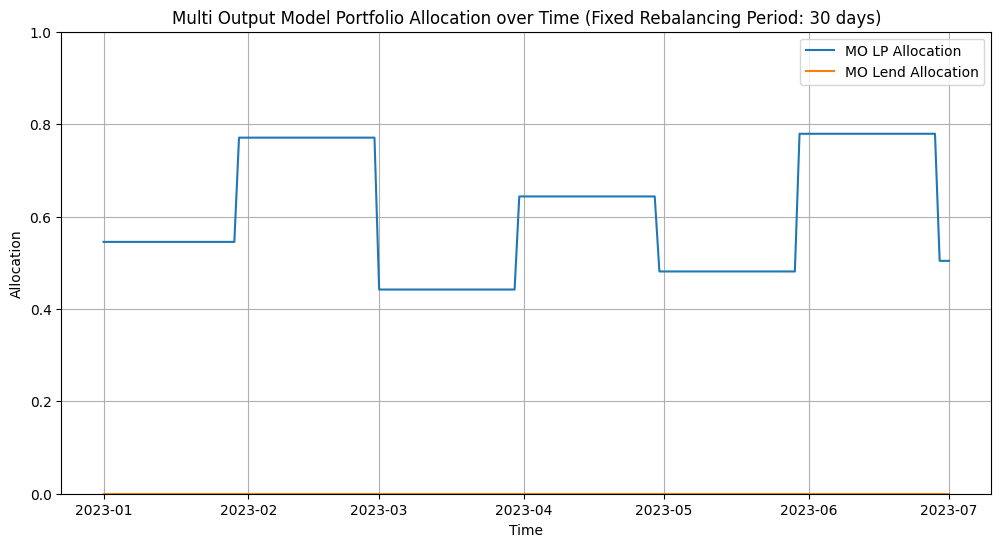

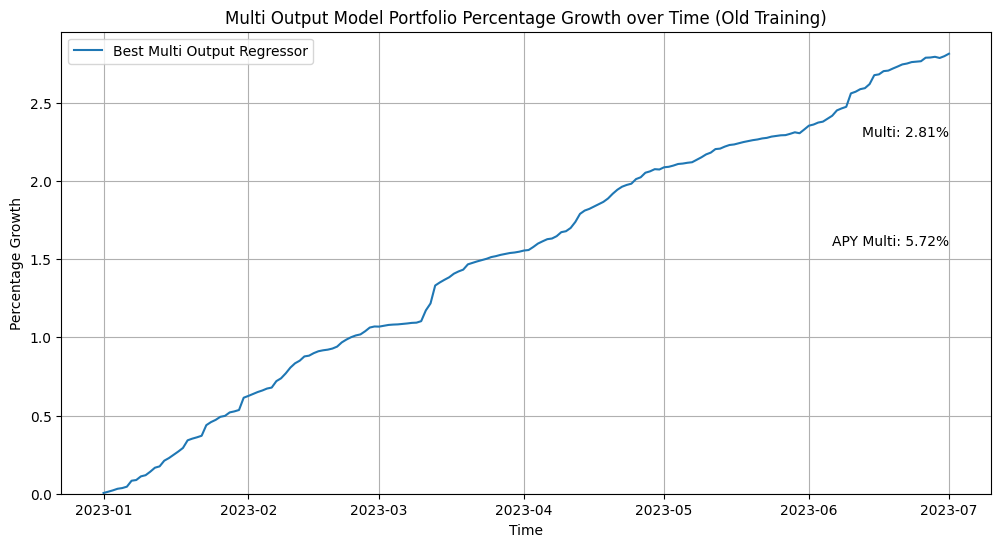

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the new test dataset without allocation columns
new_test_df = pd.read_csv('ml_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
new_test_df['block_day'] = pd.to_datetime(new_test_df['block_day'])

# Select input features
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']

# Predicted allocations using the trained ML models
predicted_allocations_multi = best_multi_model.predict(new_test_df[input_features])

# Initialize portfolio values for each model
portfolio_values_multi = np.zeros(len(new_test_df))
initial_investment = 1000  # Initial investment amount
num_assets = 2

rebalancing_period = 30  # Rebalance every 15 days
current_allocation_multi = predicted_allocations_multi[0]
portfolio_return_multi = np.zeros(2)

# Initialize portfolio allocations for each model
portfolio_allocations_multi = np.zeros((len(new_test_df), num_assets))

for i in range(len(new_test_df)):
    # Calculate the portfolio return for each model
    annualized_apy = new_test_df.iloc[i][['lp_yield', 'lend_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate the daily portfolio return adjusted for gas fees only on rebalance days
    if (i + 1) % rebalancing_period == 0:
        gas_fee = new_test_df.iloc[i]['fee_usd']  # Gas fee in USD
        adjusted_daily_returns = daily_returns - 2 * gas_fee
    else:
        adjusted_daily_returns = daily_returns
    
    portfolio_return_multi = np.dot(current_allocation_multi, adjusted_daily_returns)
    
    if i == 0:
        portfolio_values_multi[i] = initial_investment * (1 + portfolio_return_multi)
    else:
        portfolio_values_multi[i] = portfolio_values_multi[i-1] * (1 + portfolio_return_multi)
    
    # Rebalance every 5 days
    if (i + 1) % rebalancing_period == 0:
        current_allocation_multi = predicted_allocations_multi[i]

    # Store the allocations for the current time step
    portfolio_allocations_multi[i] = current_allocation_multi

# Calculate the percentage growth of the portfolios
portfolio_percentage_growth_multi = (portfolio_values_multi - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(new_test_df)
apy_multi = (portfolio_values_multi[-1] / initial_investment) ** (365 / num_days) - 1



plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 0], label='MO LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 1], label='MO Lend Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Multi Output Model Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for each model
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_multi, label='Best Multi Output Regressor')

# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Multi Output Model Portfolio Percentage Growth over Time (Old Training)')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.legend()
plt.grid(True)

plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_multi[-1]-0.5, f'Multi: {portfolio_percentage_growth_multi[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2.5, f'APY Multi: {apy_multi:.2%}', ha='right', va='top')
plt.show()



We can see that the model trained on the 3 yield source data doesn't perform as well, s it completely disocunts the Lend Yield (mimicking the 3 yield source portfolio).

The model needs to be retrained on the new MPT appraoch that would obtain allocations for the 2 yields.

In [120]:
import numpy as np
import cvxpy as cp
import pandas as pd

# Given data and parameters
risk_aversion = 0.5  # Risk aversion level
window_size = 31  # Number of previous time steps to consider (including the current step)
num_assets = 2  # Number of assets

# Read the merged CSV file with gas fees
merged_df = pd.read_csv('eth_full_data.csv')

# Convert 'block_day' column to datetime type
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Initialize the portfolio allocations and values
portfolio_allocations = np.zeros((len(merged_df), num_assets))
portfolio_values = np.zeros(len(merged_df))
initial_investment = 1000  # Initial investment amount

# Iterate through the data to calculate allocations and track portfolio performance
for i in range(window_size, len(merged_df)):
    # Select the data for the previous window_size time steps
    prev_data = merged_df.iloc[i-window_size+1:i+1]

    # Extract the average APYs and standard deviations
    average_apy = prev_data[['lp_yield', 'lend_yield']].mean().values
    std_devs = prev_data[['lp_yield', 'lend_yield']].std().values

    # Define the variable for weights
    weights = cp.Variable(num_assets)

    # Define the expected return and risk
    expected_return = cp.sum(weights * average_apy)
    risk = cp.quad_form(weights, np.diag(std_devs))

    # Define the objective to maximize the utility function
    objective = cp.Maximize(expected_return - risk_aversion * risk)

    # Define the constraints - sum of weights equal to 1 and weights >= 0
    constraints = [cp.sum(weights) == 1, weights >= 0]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Store the optimal allocation for the current time step
    portfolio_allocations[i] = weights.value

    # Calculate the portfolio value based on the allocation and annualized APYs
    allocation = portfolio_allocations[i]
    annualized_apy = merged_df.iloc[i][['lp_yield', 'lend_yield']].values
    gas_fee = merged_df.iloc[i]['fee_usd']  # Gas fee in USD
    daily_returns = (1 + annualized_apy) ** (1/365) - 1

    # Calculate the portfolio return for the current time step
    # Adjust the daily returns for gas fees (buying and selling)
    adjusted_daily_returns = daily_returns - 2 * gas_fee
    portfolio_return = np.dot(allocation, adjusted_daily_returns)

    # Calculate the portfolio value by compounding the returns
    if i == window_size:
        portfolio_values[i] = initial_investment * (1 + portfolio_return)
    else:
        portfolio_values[i] = portfolio_values[i-1] * (1 + portfolio_return)

# Calculate the percentage growth of the portfolio
portfolio_percentage_growth = (portfolio_values - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(merged_df)
apy = (portfolio_values[-1] / initial_investment) ** (365 / num_days) - 1

# Calculate and add new columns to the DataFrame
merged_df['lp_allocation'] = portfolio_allocations[:, 0]
merged_df['lend_allocation'] = portfolio_allocations[:, 1]

# Calculate moving average 30-day return, Sharpe ratio, and volatility for each asset
merged_df['lp_30ma_return'] = merged_df['lp_yield'].rolling(window=30).mean()
merged_df['lend_30ma_return'] = merged_df['lend_yield'].rolling(window=30).mean()
merged_df['stake_30ma_return'] = merged_df['stake_yield'].rolling(window=30).mean()

merged_df['lp_30ma_volatility'] = merged_df['lp_yield'].rolling(window=30).std()
merged_df['lend_30ma_volatility'] = merged_df['lend_yield'].rolling(window=30).std()
merged_df['stake_30ma_volatility'] = merged_df['stake_yield'].rolling(window=30).std()

merged_df['lp_30ma_sharpe_ratio'] = (merged_df['lp_30ma_return'] / merged_df['lp_30ma_volatility']) * np.sqrt(365)
merged_df['lend_30ma_sharpe_ratio'] = (merged_df['lend_30ma_return'] / merged_df['lend_30ma_volatility']) * np.sqrt(365)
merged_df['stake_30ma_sharpe_ratio'] = (merged_df['stake_30ma_return'] / merged_df['stake_30ma_volatility']) * np.sqrt(365)

# Print or visualize the added columns if needed
print(merged_df[['block_day', 'lp_allocation', 'lend_allocation', 'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']])


     block_day  lp_allocation  lend_allocation  lp_30ma_return  \
0   2022-09-01       0.000000         0.000000             NaN   
1   2022-09-02       0.000000         0.000000             NaN   
2   2022-09-03       0.000000         0.000000             NaN   
3   2022-09-04       0.000000         0.000000             NaN   
4   2022-09-05       0.000000         0.000000             NaN   
..         ...            ...              ...             ...   
300 2023-06-30       0.672331         0.327669        0.080023   
301 2023-07-01       0.674077         0.325923        0.080024   
302 2023-07-02       0.654174         0.345826        0.080623   
303 2023-07-03       0.697689         0.302311        0.086546   
304 2023-07-04       0.707848         0.292152        0.088338   

     lend_30ma_return  stake_30ma_return  lp_30ma_volatility  \
0                 NaN                NaN                 NaN   
1                 NaN                NaN                 NaN   
2              

In [121]:
# Convert 'block_day' column to datetime type (if not already done)
merged_df['block_day'] = pd.to_datetime(merged_df['block_day'])

# Define the date ranges
start_date_ml_training = pd.Timestamp('2022-10-01')
end_date_ml_training = pd.Timestamp('2022-12-31')

# Create the three new datasets
ml_training_dataset = merged_df[(merged_df['block_day'] >= start_date_ml_training) & (merged_df['block_day'] <= end_date_ml_training)]

# Save the three new datasets into separate CSV files
ml_training_dataset.to_csv('ml_training_dataset_2assets.csv', index=False)



In [122]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load the DataFrame with added columns
merged_df = pd.read_csv('ml_training_dataset_2assets.csv')

# Select input features and target variables
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']
target_columns = ['lp_allocation', 'lend_allocation']

# Split the data into input features (X) and target variables (y)
X = merged_df[input_features]
y = merged_df[target_columns]

In [123]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest hyperparameters
rf_param_grid = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 5, 10]}

# Tune the Random Forest for each output
best_rf_models = {}
for target_column in target_columns:
    rf_model = RandomForestRegressor()
    rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5)
    rf_grid.fit(X, y[target_column])
    best_rf_models[target_column] = rf_grid.best_estimator_
    print(f"Best Random Forest Hyperparameters for {target_column}:", rf_grid.best_params_)

# Define the parameter grid for MultiOutputRegressor hyperparameters
multi_param_grid = {'estimator': [best_rf_models['lp_allocation'], 
                                  best_rf_models['lend_allocation']],
                    'n_jobs': [-1, 1]}  # Use all CPU cores or single core

# Tune the MultiOutputRegressor
multi_rf_model = MultiOutputRegressor(RandomForestRegressor())
multi_grid = GridSearchCV(multi_rf_model, multi_param_grid, cv=5)
multi_grid.fit(X, y)
best_multi_model = multi_grid.best_estimator_
print("Best MultiOutputRegressor Hyperparameters:", multi_grid.best_params_)

Best Random Forest Hyperparameters for lp_allocation: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Hyperparameters for lend_allocation: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best MultiOutputRegressor Hyperparameters: {'estimator': RandomForestRegressor(min_samples_split=5, n_estimators=50), 'n_jobs': -1}


In [124]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Train the MultiOutputRegressor with the best parameters
best_multi_model = MultiOutputRegressor(RandomForestRegressor(min_samples_split=5, n_estimators=50), n_jobs=-1)
best_multi_model.fit(X, y)


MultiOutputRegressor(estimator=RandomForestRegressor(min_samples_split=5,
                                                     n_estimators=50),
                     n_jobs=-1)

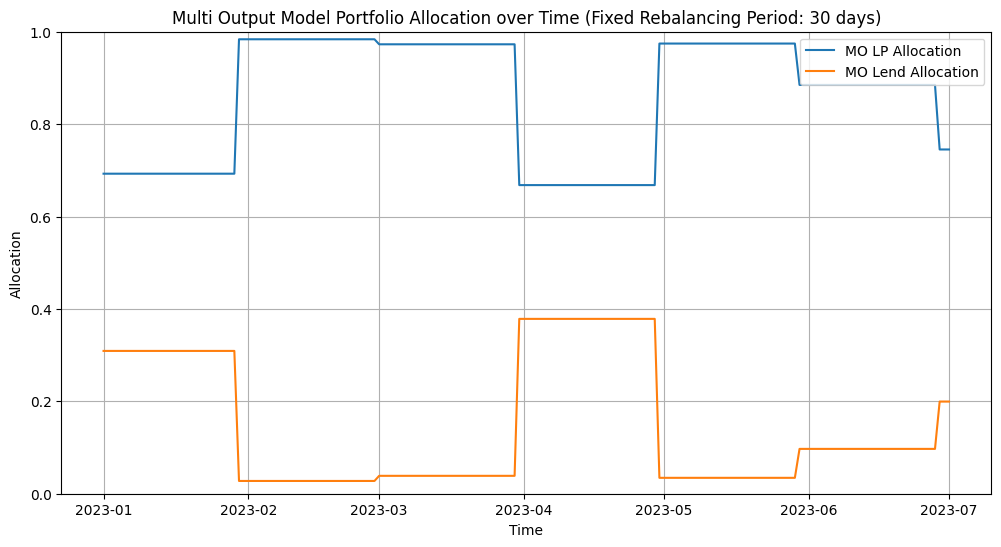

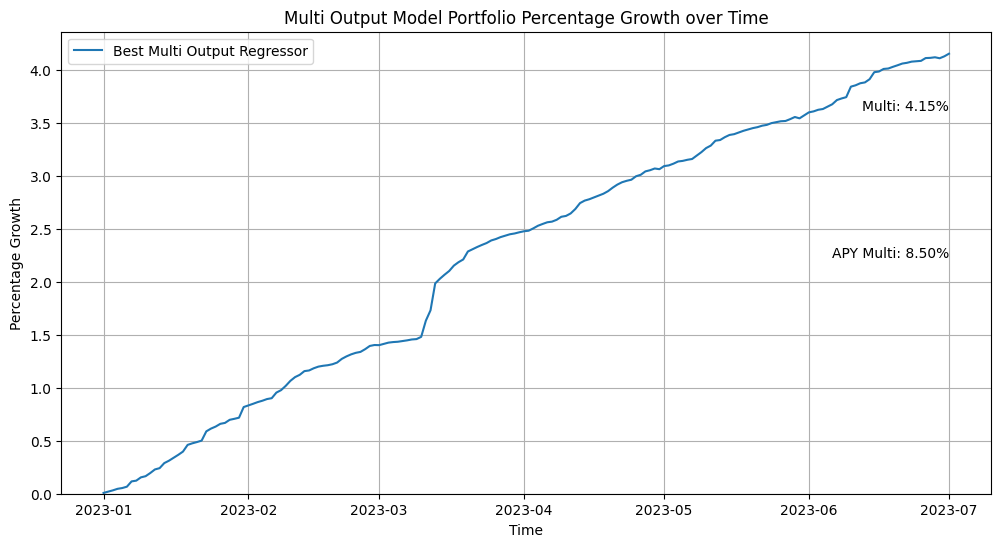

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the new test dataset without allocation columns
new_test_df = pd.read_csv('ml_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
new_test_df['block_day'] = pd.to_datetime(new_test_df['block_day'])

# Select input features
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']

# Predicted allocations using the trained ML models
predicted_allocations_multi = best_multi_model.predict(new_test_df[input_features])

# Initialize portfolio values for each model
portfolio_values_multi = np.zeros(len(new_test_df))
initial_investment = 1000  # Initial investment amount
num_assets = 2

rebalancing_period = 30  # Rebalance every 15 days
current_allocation_multi = predicted_allocations_multi[0]
portfolio_return_multi = np.zeros(2)

# Initialize portfolio allocations for each model
portfolio_allocations_multi = np.zeros((len(new_test_df), num_assets))

for i in range(len(new_test_df)):
    # Calculate the portfolio return for each model
    annualized_apy = new_test_df.iloc[i][['lp_yield', 'lend_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate the daily portfolio return adjusted for gas fees only on rebalance days
    if (i + 1) % rebalancing_period == 0:
        gas_fee = new_test_df.iloc[i]['fee_usd']  # Gas fee in USD
        adjusted_daily_returns = daily_returns - 2 * gas_fee
    else:
        adjusted_daily_returns = daily_returns
    
    portfolio_return_multi = np.dot(current_allocation_multi, adjusted_daily_returns)
    
    if i == 0:
        portfolio_values_multi[i] = initial_investment * (1 + portfolio_return_multi)
    else:
        portfolio_values_multi[i] = portfolio_values_multi[i-1] * (1 + portfolio_return_multi)
    
    # Rebalance every 5 days
    if (i + 1) % rebalancing_period == 0:
        current_allocation_multi = predicted_allocations_multi[i]

    # Store the allocations for the current time step
    portfolio_allocations_multi[i] = current_allocation_multi

# Calculate the percentage growth of the portfolios
portfolio_percentage_growth_multi = (portfolio_values_multi - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(new_test_df)
apy_multi = (portfolio_values_multi[-1] / initial_investment) ** (365 / num_days) - 1

plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 0], label='MO LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 1], label='MO Lend Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Multi Output Model Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for each model
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_multi, label='Best Multi Output Regressor')

# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Multi Output Model Portfolio Percentage Growth over Time')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.legend()
plt.grid(True)

plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_multi[-1]-0.5, f'Multi: {portfolio_percentage_growth_multi[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2.5, f'APY Multi: {apy_multi:.2%}', ha='right', va='top')
plt.show()



After retraining the model we can see it still does not manage to outperform the pure MPT appraoch. Perhaps Linear Regression will behave better, given it was very close to MO in terms of perfomrance before. We retrain and test.

In [126]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Train the MultiOutputRegressor with the best parameters
best_multi_model = LinearRegression()
best_multi_model.fit(X, y)


LinearRegression()

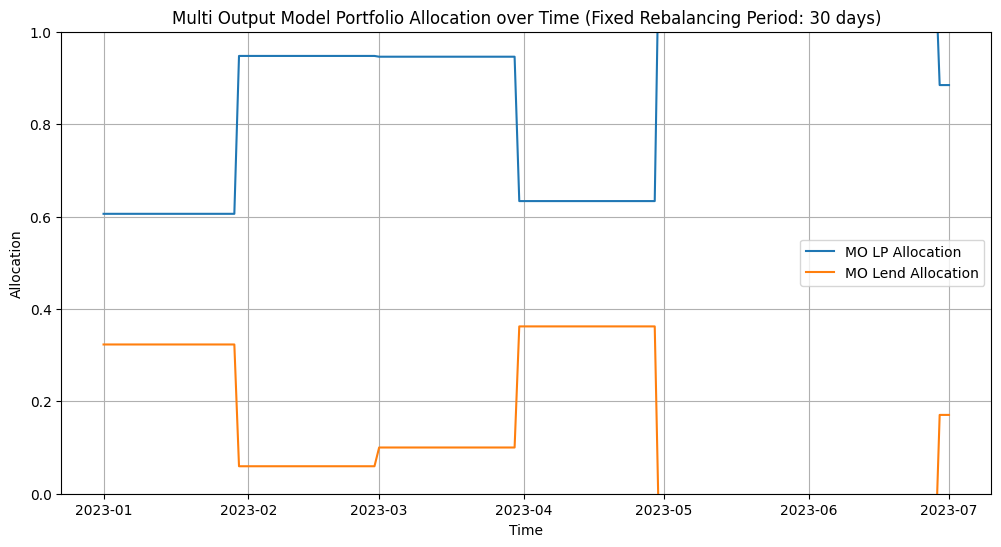

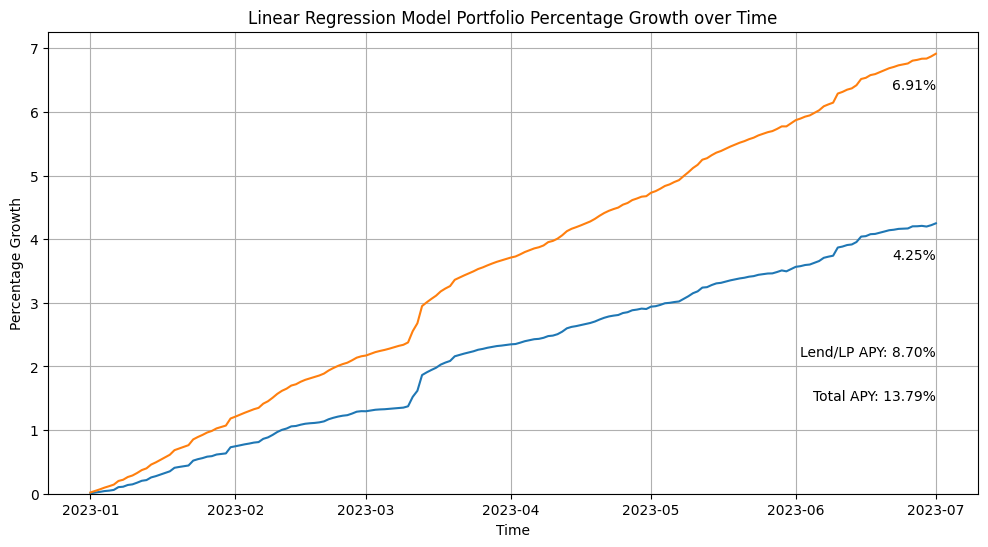

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the new test dataset without allocation columns
new_test_df = pd.read_csv('ml_evaluation_dataset.csv')

# Convert 'block_day' column to datetime type
new_test_df['block_day'] = pd.to_datetime(new_test_df['block_day'])

# Select input features
input_features = ['lp_yield', 'lend_yield', 'stake_yield', 'close_price', 'fee_usd',
                  'lp_30ma_return', 'lend_30ma_return', 'stake_30ma_return', 
                  'lp_30ma_volatility', 'lend_30ma_volatility', 'stake_30ma_volatility', 
                  'lp_30ma_sharpe_ratio', 'lend_30ma_sharpe_ratio', 'stake_30ma_sharpe_ratio']

# Predicted allocations using the trained ML models
predicted_allocations_multi = best_multi_model.predict(new_test_df[input_features])

# Initialize portfolio values for each model
portfolio_values_multi = np.zeros(len(new_test_df))
initial_investment = 1000  # Initial investment amount
num_assets = 2

rebalancing_period = 30  # Rebalance every 15 days
current_allocation_multi = predicted_allocations_multi[0]
portfolio_return_multi = np.zeros(2)

# Initialize portfolio allocations for each model
portfolio_allocations_multi = np.zeros((len(new_test_df), num_assets))

for i in range(len(new_test_df)):
    # Calculate the portfolio return for each model
    annualized_apy = new_test_df.iloc[i][['lp_yield', 'lend_yield']].values
    daily_returns = (1 + annualized_apy) ** (1/365) - 1
    
    # Calculate the daily portfolio return adjusted for gas fees only on rebalance days
    if (i + 1) % rebalancing_period == 0:
        gas_fee = new_test_df.iloc[i]['fee_usd']  # Gas fee in USD
        adjusted_daily_returns = daily_returns - 2 * gas_fee
    else:
        adjusted_daily_returns = daily_returns
    
    portfolio_return_multi = np.dot(current_allocation_multi, adjusted_daily_returns)
    
    if i == 0:
        portfolio_values_multi[i] = initial_investment * (1 + portfolio_return_multi)
    else:
        portfolio_values_multi[i] = portfolio_values_multi[i-1] * (1 + portfolio_return_multi)
    
    # Rebalance every 5 days
    if (i + 1) % rebalancing_period == 0:
        current_allocation_multi = predicted_allocations_multi[i]

    # Store the allocations for the current time step
    portfolio_allocations_multi[i] = current_allocation_multi

# Calculate the percentage growth of the portfolios
portfolio_percentage_growth_multi = (portfolio_values_multi - initial_investment) / initial_investment * 100

# Calculate the APY for the given portfolio growth
num_days = len(new_test_df)
apy_multi = (portfolio_values_multi[-1] / initial_investment) ** (365 / num_days) - 1

combined_portfolio_growth = portfolio_percentage_growth_multi + df['percentage_growth'].iloc[31:]
combined_apy = (((combined_portfolio_growth[212] / 100)) / 183) * 365

plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 0], label='MO LP Allocation')
plt.plot(new_test_df['block_day'], portfolio_allocations_multi[:, 1], label='MO Lend Allocation')
plt.xlabel('Time')
plt.ylabel('Allocation')
plt.title(f'Multi Output Model Portfolio Allocation over Time (Fixed Rebalancing Period: {rebalancing_period} days)')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time for each model
plt.figure(figsize=(12, 6))
plt.plot(new_test_df['block_day'], portfolio_percentage_growth_multi, label='Linear Regression')
plt.plot(new_test_df['block_day'], combined_portfolio_growth, label='Combined Portfolio')

# # Set the x-axis tick frequency to show every month
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Format the x-axis dates as month-year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

plt.xlabel('Time')
plt.ylabel('Percentage Growth')
plt.title('Linear Regression Model Portfolio Percentage Growth over Time')
plt.ylim(bottom=0)  # Set the lower y-axis limit to zero
plt.grid(True)

plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth_multi[-1]-0.5, f'{portfolio_percentage_growth_multi[-1]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], combined_portfolio_growth[212]-0.5, f'{combined_portfolio_growth[212]:.2f}%',
         ha='right', va='center')
plt.text(new_test_df['block_day'].values[-1], portfolio_percentage_growth[-1] - 2.5, f'Lend/LP APY: {apy_multi:.2%}', ha='right', va='top')
plt.text(new_test_df['block_day'].values[-1], combined_apy + 1.5, f'Total APY: {combined_apy:.2%}', ha='right', va='top')

plt.show()



The Linear Regression outperformed all other approaches, including both the static and dynamic MPT approach as well as the tuned Multi Output Model. This resulted in an APY of 8.70% (13.79% including the “given” Stake Yield), which is the highest APY for this period out of all the previous scenarios, both 2 and 3 yield source ones.

### Conclusions 

Initially the assumption was that the MPT approach and ML Modelling approach would be completely separate, and would be analyzed as “competing” methods. Already during the research phase and while assembling the proposal for this work, the hypothesis has shifted to a claim that the ML approach will most likely be complementary to the MPT approach and won’t have to rival the results, but use them as fundamental guidance for the more complex logic.

This proved to be true after realizing that the MPT output might have to be used as training target data for the model, or otherwise we wouldn't be able to have the model predict our allocations. In the end, it turns out that the best approach is to merge the two together, in order to generate more alpha out of the portfolio.